# Visualisation of the semantic space using GloVe embeddings

Following Pennington et al. (2014) and Grand et al. (2022). We use 50-dimensional mathematical embeddings, like in the analysis of the behavioural data.

## Imports

In [1]:
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter('ignore', FutureWarning)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.spatial.distance import cdist
from itertools import combinations, product
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
import ast
from tqdm.notebook import tqdm
from IPython.display import display, Markdown
import os
import subprocess

In [3]:
%matplotlib inline
custom = {'figure.figsize': (11.7,8.27), 'font.size':11, 'font.family': 'Arial', 'font.sans-serif': 'Arial'}
sns.set_theme(style="ticks", rc=custom)
plt.rcParams['svg.fonttype'] = 'none'
figWidth = 7.677165 # 19.5cm pour PLOS
ratio = 8.27/11.7

In [4]:
vectors = pd.read_csv("../../../Embeddings/French/words_vec_50_maths.csv", encoding='utf-8', index_col='word')

## Computations on the whole dataset

In [5]:
tSNE = TSNE(n_components=2)
tSNEProjections = pd.DataFrame(tSNE.fit_transform(vectors.to_numpy()), index=vectors.index)

In [6]:
pca = PCA(n_components=2)
pcaProjections = pd.DataFrame(pca.fit_transform(vectors.to_numpy()), index=vectors.index)

In [7]:
mds = MDS(n_components=2, metric=False)
mdsProjections = pd.DataFrame(mds.fit_transform(vectors.to_numpy()), index=vectors.index)

## Definitions

In [8]:
def plotMatrix(data, var1, var2, label1=None, label2=None, ax=None, show=True, save=False, name=None, **kwargs):
    df = data.loc[var1+var2]

    distMatArray = cdist(df.to_numpy(), df.to_numpy(), lambda x,y: np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y)))
    distMat = pd.DataFrame(distMatArray, index=df.index, columns=df.index)

    ax = ax or plt.gca()
    label1 = label1 or var1
    label2 = label2 or var2

    sns.heatmap(distMat, ax=ax, cmap='rocket_r', **kwargs)
    
    ax.axhline(len(var1), color='black')
    ax.axvline(len(var1), color='black')
    ax.set(xlabel="", ylabel="")
    ax.set_xticks(ax.get_xticks(), label1+label2, rotation=30, ha='left')
    ax.set_yticks(ax.get_yticks(), label1+label2)
    ax.xaxis.tick_top()
    plt.tight_layout()

    if save:
        plt.savefig(name, dpi=300)

    if show:
        plt.show()
        plt.clf()

    return ax

In [9]:
def printReport(data, var1, var2):
    df = data.loc[var1+var2]

    distMatArray = cdist(df.to_numpy(), df.to_numpy(), lambda x,y: np.dot(x,y)/(np.linalg.norm(x)*np.linalg.norm(y)))
    distMat = pd.DataFrame(distMatArray, index=df.index, columns=df.index)

    pairsIntraGroup = list(combinations(var1, 2)) + list(combinations(var2, 2))
    pairsInterGroup = product(var1, var2)

    distIntraGroup = [distMat.loc[w1][w2] for w1, w2 in pairsIntraGroup]
    distInterGroup = [distMat.loc[w1][w2] for w1, w2 in pairsInterGroup]

    print(f"Intra groups:\n{pd.DataFrame(distIntraGroup).describe()}\n\n")
    print(f"Inter groups:\n{pd.DataFrame(distInterGroup).describe()}\n\n")

    ttest = stats.ttest_ind(distIntraGroup, distInterGroup)
    p = ttest.pvalue
    if p < .001:
        signif = " (***)"
    elif p < .01:
        signif = " (**)"
    elif p < .05:
        signif = " (*)"
    else:
        signif = ""
    print(f"t-test of independence: t({len(distIntraGroup)+len(distInterGroup)-2}) = {ttest.statistic:.2f}, p = {p:.2e}{signif}")


In [10]:
def textplot(projection, var1, var2, label1=None, label2=None, size=12, ax=None, show=False, save=False, name=None, **kwargs):
    """
    projection: dataframe of projected coordinates
    var1, var2: lists of words
    """
    ax = ax or plt.gca()

    label1 = label1 or var1
    label2 = label2 or var2

    projectionRestricted = projection.loc[var1+var2]

    ax.scatter(projectionRestricted[0], projectionRestricted[1], c='black')
    for v1, v2, l1, l2 in zip(var1, var2, label1, label2):
        ax.plot([projectionRestricted.loc[v1][0], projectionRestricted.loc[v2][0]], [projectionRestricted.loc[v1][1], projectionRestricted.loc[v2][1]], '--', c='grey')
        ax.text(x=projectionRestricted.loc[v1][0], y=projectionRestricted.loc[v1][1]+.07, s=l1, verticalalignment='bottom', horizontalalignment='center', size=size)
        ax.text(x=projectionRestricted.loc[v2][0], y=projectionRestricted.loc[v2][1]+.07, s=l2, verticalalignment='bottom', horizontalalignment='center', size=size)
    
    plt.tight_layout()

    if save:
        plt.savefig(name, dpi=300)

    if show:
        plt.show()
        plt.clf()

    return ax

In [11]:
def transPCA(data, var1, var2):
    df1 = data.loc[var1]
    df2 = data.loc[var2]
    df = pd.concat([df1, df2])

    pca = PCA(n_components=2)
    fitPCA = pca.fit(df.to_numpy())
    projections = pd.DataFrame(fitPCA.transform(df.to_numpy()), index=df.index)

    return fitPCA, projections

In [12]:
def transtSNE(data, var1, var2, ppl=9):
    df1 = data.loc[var1]
    df2 = data.loc[var2]
    df = pd.concat([df1, df2])

    perpl = ppl if len(df) > ppl else len(df)-1
    tsne = TSNE(n_components=2, perplexity=perpl)
    fitTSNE = tsne.fit(df.to_numpy())
    projections = pd.DataFrame(tsne.fit_transform(df.to_numpy()), index=df.index)

    return fitTSNE, projections

In [13]:
def transMDS(data, var1, var2):
    df1 = data.loc[var1]
    df2 = data.loc[var2]
    df = pd.concat([df1, df2])

    mds = MDS(n_components=2, metric=False)
    fitMDS = mds.fit(df.to_numpy())
    projections = pd.DataFrame(mds.fit_transform(df.to_numpy()), index=df.index)

    return fitMDS, projections

In [14]:
def projSimMatrix(data, var1, var2, proj='pca', ax=None, show=True, save=False, name=None):
    df = data.loc[var1+var2]

    if proj == 'pca':
        model = PCA(n_components=2)
    elif proj == 'tsne':
        perpl = 9 if len(df) > 9 else len(df)-1
        model = TSNE(n_components=2, perplexity=perpl)
    elif proj == 'mds':
        model = MDS(n_components=2, metric=False)

    projections = pd.DataFrame(model.fit_transform(df.to_numpy()), index=df.index)

    ax = ax or plt.gca()
    plotMatrix(projections, var1, var2, ax=ax, show=False)
    printReport(projections, var1, var2)

    if save:
        plt.savefig(name, dpi=300)

    if show:
        plt.show()
        plt.clf()

    return ax

In [15]:
def PCApairplot(data, var1, var2):
    df1 = data.loc[var1]
    df2 = data.loc[var2]
    df = pd.concat([df1, df2])

    pca = PCA()
    fitPCA = pca.fit(df.to_numpy())

    expVar = np.cumsum(pca.explained_variance_ratio_)
    nKeepDim = len([i for i, x in enumerate(expVar) if x < .8])
    keepDim = [i for i in range(nKeepDim+1)]

    projections = pd.DataFrame(fitPCA.transform(df.to_numpy()), index=df.index)[keepDim]

    def tplot(x,y,**kwargs):
        n = len(x)
        ax = plt.gca()
        ax.scatter(x, y, c='black')
        for i, (v1, v2) in enumerate(zip(var1, var2)):
            ax.plot([x[i], x[i+n//2]], [y[i], y[i+n//2]], '--', c='grey')
            ax.text(x=x[i], y=y[i]+.07, s=v1, verticalalignment='bottom', horizontalalignment='center', size=12)
            ax.text(x=x[i+n//2], y=y[i+n//2]+.07, s=v2, verticalalignment='bottom', horizontalalignment='center', size=12)
        plt.tight_layout()
        return ax
    
    def diag(x,**kwargs):
        for i in range(len(keepDim)):
            if np.array_equal(projections[i].to_numpy(), x):
                ind = i
        evar = pca.explained_variance_ratio_[ind]
        ax = plt.gca()
        sns.kdeplot(x, color='black', ax=ax)
        plt.text(x[0], .1, f'% explained var: {evar*100:.1f}')
        return ax

    g = sns.PairGrid(projections, vars=keepDim, corner=True, height=5, aspect=1)
    g.map_lower(tplot)
    g.map_diag(diag)

    plt.show()
    plt.clf()

In [16]:
def computeDistance(data, bounds, points):
    assert len(bounds) == 2
    w1, w2 = bounds
    
    axis = np.array(data.loc[w2])-np.array(data.loc[w1])
    normAxis = axis / np.linalg.norm(axis)

    df = data.loc[points]

    distances = []
    for p in df.itertuples():
        distances.append(np.dot(normAxis, p[1:]))

    return pd.DataFrame({'Coordinate': distances}, index=df.index)

In [17]:
def plotDistance(data, bounds, points):
    w1, w2 = bounds

    dist = computeDistance(data, bounds, points)

    plt.plot([dist.loc[w1].Coordinate, dist.loc[w2].Coordinate], [1,1], c='.8', linestyle='--')
    plt.scatter(dist['Coordinate'], np.ones(len(dist)), c='black')
    for i, p in enumerate(points):
        y, va = (1.002, 'bottom') if i%2 == 0 else (0.998, 'top')
        plt.text(dist.loc[p].Coordinate, y, p, rotation=45, ha='center', va=va)

    plt.show()
    plt.clf()


## Organisation of numbers

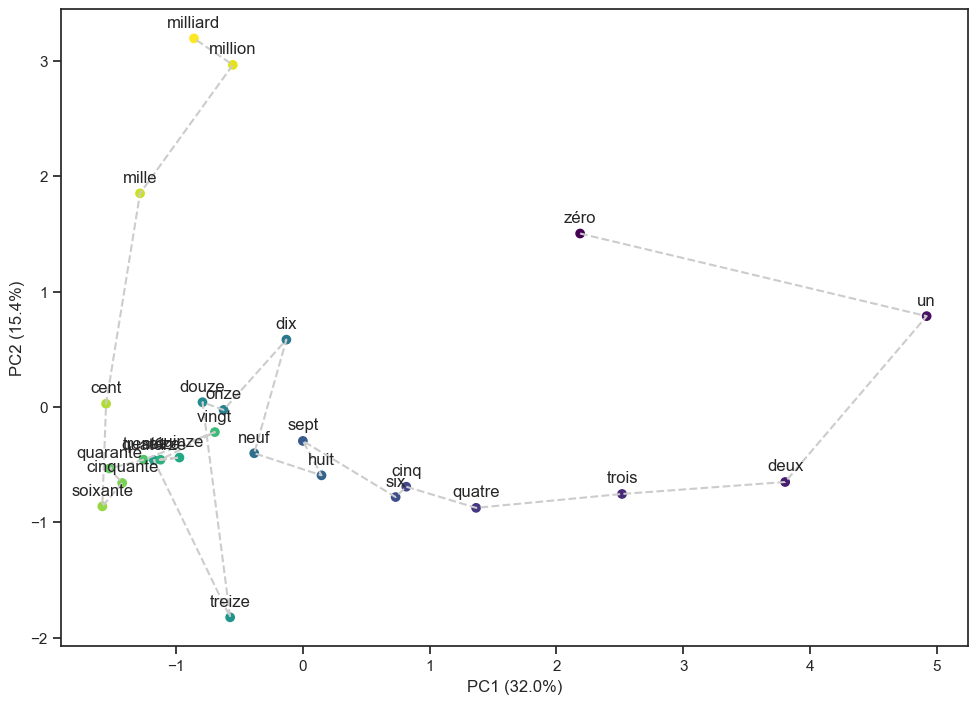

<Figure size 1170x827 with 0 Axes>

In [18]:
numbers = ['zéro', 'un', 'deux', 'trois', 'quatre', 'cinq', 'six', 'sept', 'huit', 'neuf', 'dix', 'onze', 'douze', 'treize', 'quatorze', 'quinze', 'seize', 'vingt', 'trente', 'quarante', 'cinquante', 'soixante', 'cent', 'mille', 'million', 'milliard']

pca = PCA(n_components=2)
numbersPCA = pd.DataFrame(pca.fit_transform(vectors.loc[numbers]), index=numbers)
pc1, pc2 = pca.fit(vectors.loc[numbers]).explained_variance_ratio_

plt.scatter(numbersPCA[0], numbersPCA[1], c=np.arange(len(numbers)), cmap='viridis')
plt.plot(numbersPCA[0], numbersPCA[1], color='.8', linestyle='--')
for num in numbers:
    plt.text(x=numbersPCA.loc[num][0], y=numbersPCA.loc[num][1]+.07, s=num, verticalalignment='bottom', horizontalalignment='center', size=12)
plt.xlabel(f"PC1 ({pc1*100:.1f}%)")
plt.ylabel(f"PC2 ({pc2*100:.1f}%)")

plt.show()
plt.clf()

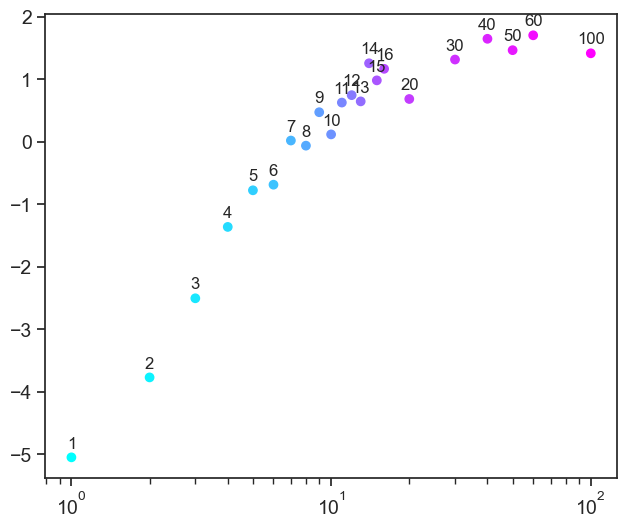

<Figure size 1170x827 with 0 Axes>

In [19]:
# article fig
numbers = ['un', 'deux', 'trois', 'quatre', 'cinq', 'six', 'sept', 'huit', 'neuf', 'dix', 'onze', 'douze', 'treize', 'quatorze', 'quinze', 'seize', 'vingt', 'trente', 'quarante', 'cinquante', 'soixante', 'cent']
numbersEnglish = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen','sixteen', 'twenty', 'thirty', 'fourty', 'fifty', 'sixty', 'hundred']
values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 20, 30, 40, 50, 60, 100]

pca = PCA(n_components=1)
numbersPCA = pd.DataFrame(pca.fit_transform(vectors.loc[numbers]), index=numbers)

plt.scatter(values, -numbersPCA[0], c=np.arange(len(numbers)), cmap='cool')
# plt.plot(numbersPCA[0], numbersPCA[1], color='.8', linestyle='--')
for num, numEn, val in zip(numbers, numbersEnglish, values):
    plt.text(y=-numbersPCA.loc[num][0]+.1, x=val, s=str(val), verticalalignment='bottom', horizontalalignment='center', size=12)
# plt.xlabel(f"PC1 ({pc1*100:.1f}%)")
# plt.ylabel(f"PC2 ({pc2*100:.1f}%)")
    
plt.xscale('log')

fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(figWidth/1.2, figWidth*ratio)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)
plt.tight_layout()
# plt.savefig("VisuNumericLinePCA.svg", format="svg")
plt.show()
plt.clf()

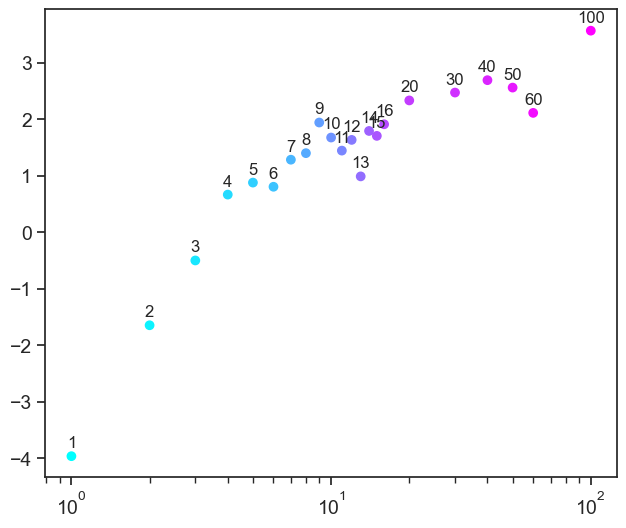

<Figure size 1170x827 with 0 Axes>

In [20]:
numbers = ['un', 'deux', 'trois', 'quatre', 'cinq', 'six', 'sept', 'huit', 'neuf', 'dix', 'onze', 'douze', 'treize', 'quatorze', 'quinze', 'seize', 'vingt', 'trente', 'quarante', 'cinquante', 'soixante', 'cent']
numbersEnglish = ['one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'eleven', 'twelve', 'thirteen', 'fourteen', 'fifteen','sixteen', 'twenty', 'thirty', 'fourty', 'fifty', 'sixty', 'hundred']
values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 20, 30, 40, 50, 60, 100]

dist = computeDistance(vectors, ['un', 'cent'], numbers)

plt.scatter(values, dist.Coordinate, c=np.arange(len(numbers)), cmap='cool')
# plt.plot(numbersPCA[0], numbersPCA[1], color='.8', linestyle='--')
for num, numEn, val in zip(numbers, numbersEnglish, values):
    plt.text(y=dist.loc[num].Coordinate+.1, x=val, s=str(val), verticalalignment='bottom', horizontalalignment='center', size=12)
# plt.xlabel(f"PC1 ({pc1*100:.1f}%)")
# plt.ylabel(f"PC2 ({pc2*100:.1f}%)")
    
plt.xscale('log')

fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(figWidth/1.2, figWidth*ratio)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)
plt.tight_layout()
plt.show()
plt.clf()

## Mean distance between two groups of related concepts

Two indpendent groups of related concepts (e.g. algebra and analysis), compute all distances, and test whether concepts of the same groups are consistently closer than concepts of the two groups. Show similarity matrices.

### Arithmetic / Geometry

In [21]:
arith = ["addition", "soustraction", "multiplication", "modulo", "euclidien", "anneau", "entier", "Bézout", "Gauss"]
geom = ["droite", "segment", "cercle", "compas", "règle", "polygone", "projectif", "homothétie", "nappe"]

In [22]:
printReport(vectors, arith, geom)

Intra groups:
               0
count  72.000000
mean    0.397727
std     0.193149
min    -0.006657
25%     0.259583
50%     0.393476
75%     0.485024
max     0.897649


Inter groups:
               0
count  81.000000
mean    0.230848
std     0.192933
min    -0.330336
25%     0.145040
50%     0.247767
75%     0.349279
max     0.656777


t-test of independence: t(151) = 5.34, p = 3.39e-07 (***)


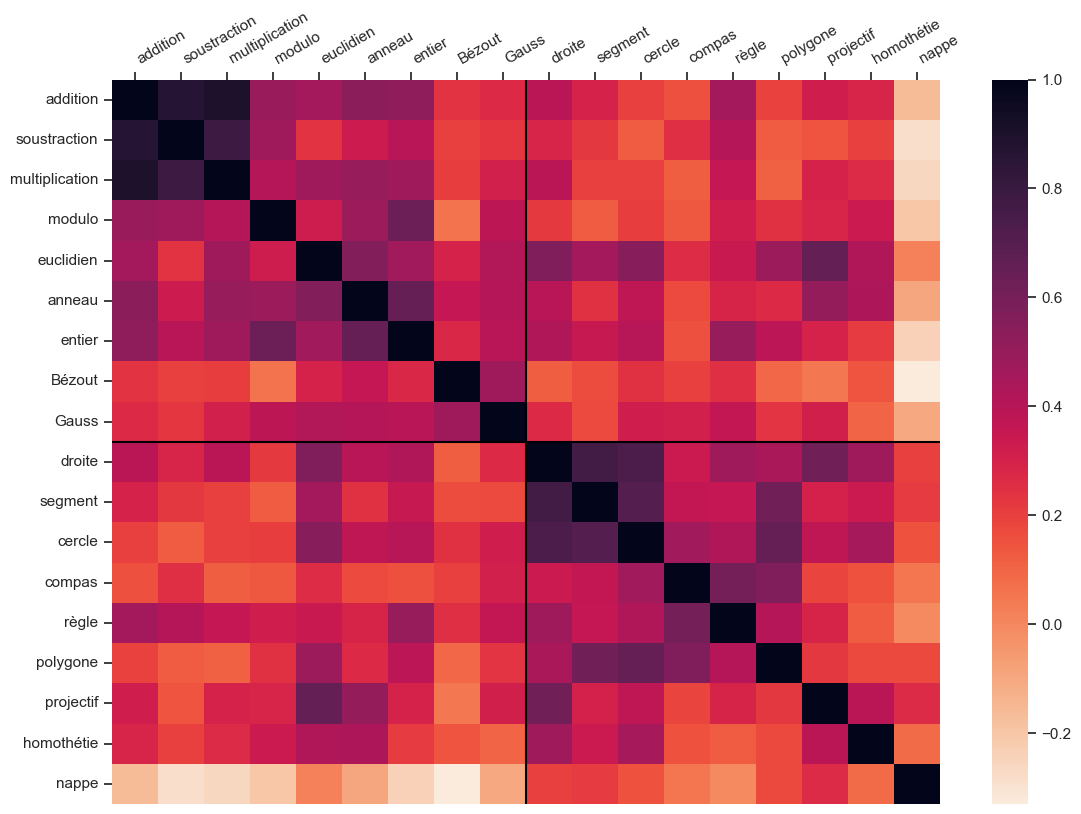

<Axes: >

<Figure size 1170x827 with 0 Axes>

In [23]:
plotMatrix(vectors, arith, geom)

### Odd / Even functions

In [24]:
oddFunc = ['sinus', 'tangente', 'inverse', 'cube']
evenFunc = ['cosinus', 'carré']

In [25]:
printReport(vectors, oddFunc, evenFunc)

Intra groups:
              0
count  7.000000
mean   0.361549
std    0.131875
min    0.208548
25%    0.263340
50%    0.319340
75%    0.461630
max    0.553012


Inter groups:
              0
count  8.000000
mean   0.497986
std    0.209013
min    0.119137
25%    0.433058
50%    0.452421
75%    0.609450
max    0.814283


t-test of independence: t(13) = -1.48, p = 1.62e-01


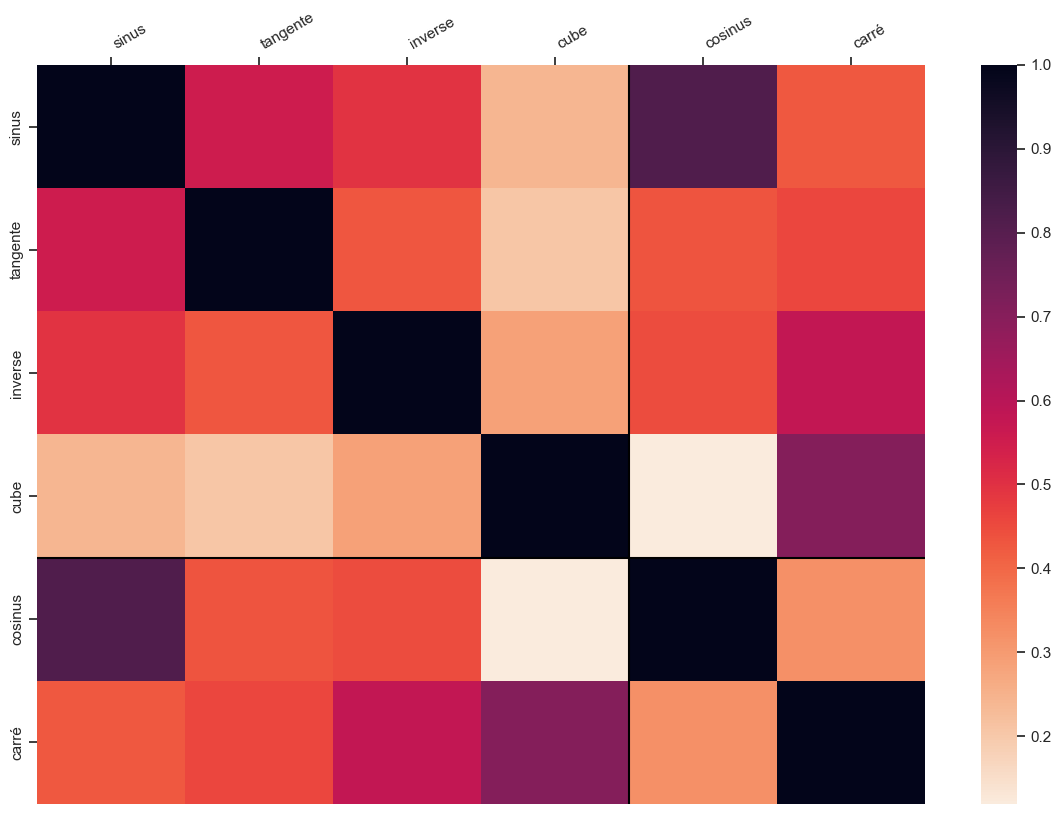

<Axes: >

<Figure size 1170x827 with 0 Axes>

In [26]:
plotMatrix(vectors, oddFunc, evenFunc)

### Odd / Even numbers

In [27]:
oddNum = ['un', 'trois', 'cinq', 'sept', 'neuf']
evenNum = ['deux', 'quatre', 'six', 'huit', 'dix']

In [28]:
printReport(vectors, oddNum, evenNum)

Intra groups:
               0
count  20.000000
mean    0.732270
std     0.177784
min     0.298343
25%     0.687226
50%     0.797400
75%     0.866534
max     0.918371


Inter groups:
               0
count  25.000000
mean    0.760917
std     0.170429
min     0.389250
25%     0.705034
50%     0.814765
75%     0.879983
max     0.944053


t-test of independence: t(43) = -0.55, p = 5.85e-01


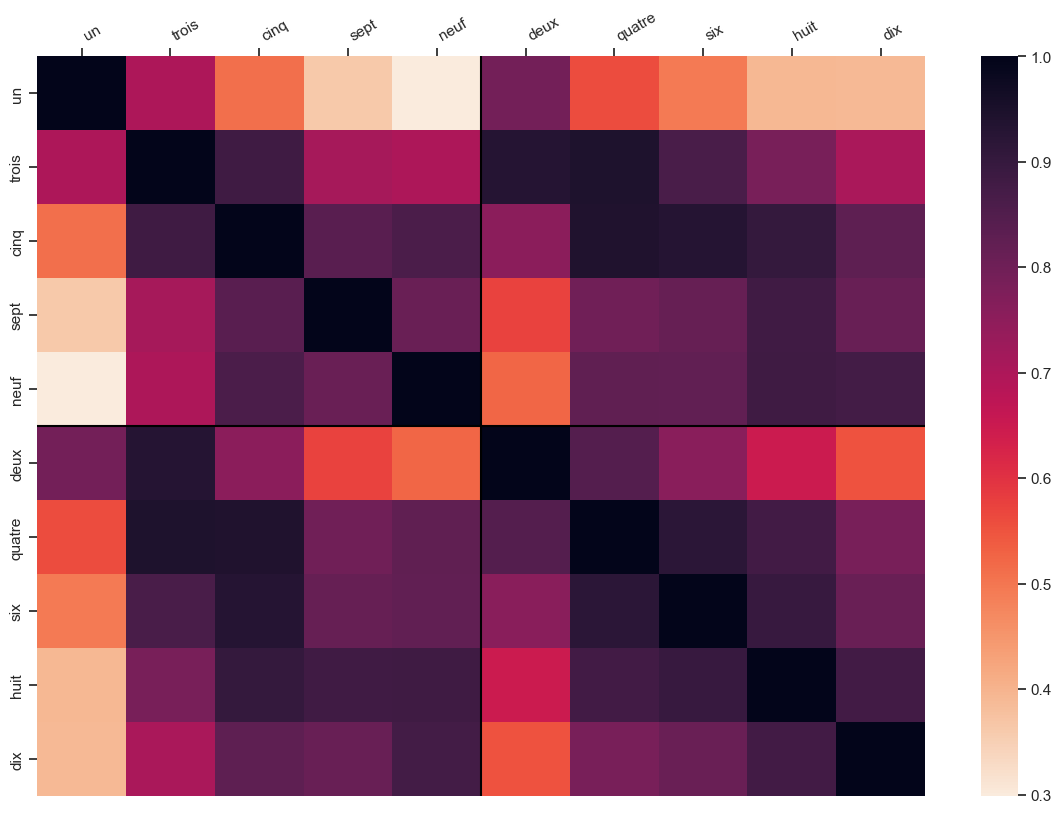

<Axes: >

<Figure size 1170x827 with 0 Axes>

In [29]:
plotMatrix(vectors, oddNum, evenNum)

### Complex analysis / Logic

In [30]:
complexAnalysis = ['pôle', 'méromorphe', 'holomorphe', 'résidu', 'Cauchy', 'harmonique', 'indice', 'Liouville']
logic = ['prédicat', 'complétude', 'Gödel', 'modèle', 'ZFC', 'théorie', 'déduction', 'Peano']

complexAnalysisEn = ['pole', 'meromorphic', 'holomorphic', 'residue', 'Cauchy', 'harmonic', 'winding index', 'Liouville']
logicEn = ['predicate', 'completeness', 'Gödel', 'model', 'ZFC', 'theory', 'deduction', 'Peano']

In [31]:
printReport(vectors, complexAnalysis, logic)

Intra groups:
               0
count  56.000000
mean    0.337212
std     0.167382
min    -0.038537
25%     0.239965
50%     0.361037
75%     0.436351
max     0.750214


Inter groups:
               0
count  64.000000
mean    0.131560
std     0.139312
min    -0.184740
25%     0.062035
50%     0.159051
75%     0.203000
max     0.416019


t-test of independence: t(118) = 7.34, p = 2.91e-11 (***)


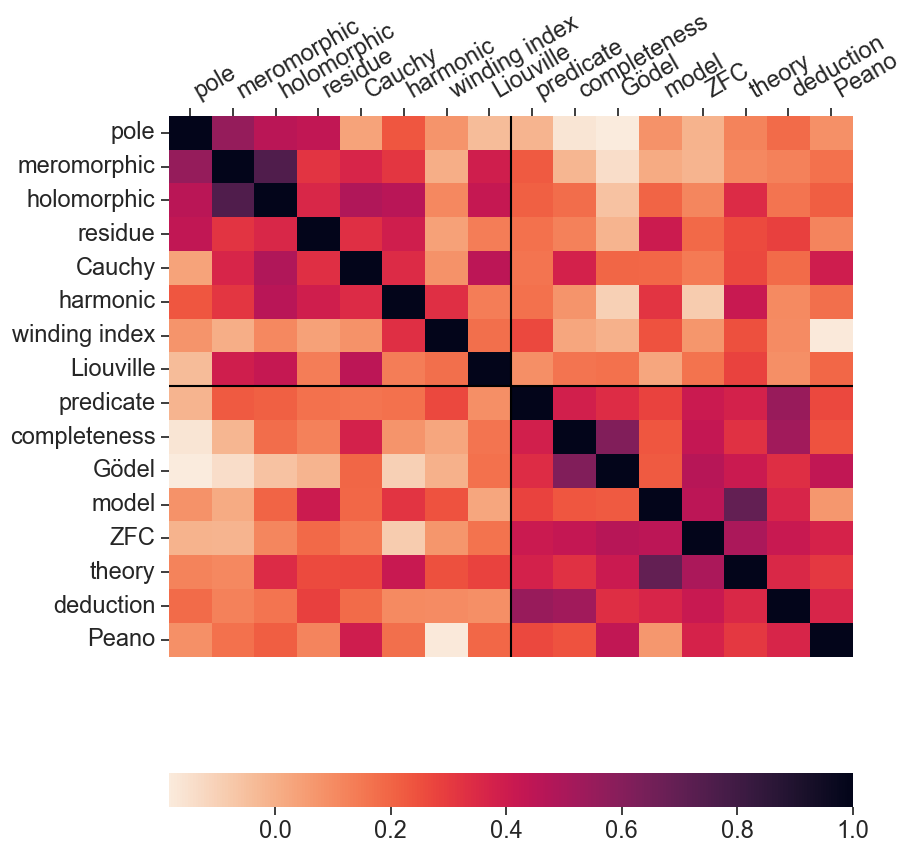

<Figure size 1170x827 with 0 Axes>

In [32]:
# article fig
ax = plotMatrix(vectors, complexAnalysis, logic, label1=complexAnalysisEn, label2=logicEn, show=False, cbar_kws=dict(location="bottom"))

fig = plt.gcf()
shrink = 1.2
fig.set_size_inches(figWidth*shrink, figWidth*ratio*1.4*shrink)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(17)
cbar = ax.collections[-1].colorbar
cbar.ax.tick_params(labelsize=17)
plt.tight_layout()
# plt.savefig("VisuLogicAnalysis.png", dpi=300)
plt.show()
plt.clf()

## Meaning of vector differences, à la Pennington et al.

In [33]:
def analyseDiff(data, var1, var2):
    fig, ax = plt.subplots(2,3, figsize=(15,10))

    model, projections = transPCA(data, var1, var2)
    pc1, pc2 = model.explained_variance_ratio_
    textplot(projections, var1, var2, ax=ax[0,0])
    ax[0,0].set(title = 'Local PCA', xlabel=f'PC1 ({pc1*100:.1f}%)', ylabel=f'PC2 ({pc2*100:.1f}%)')

    _, projections = transMDS(data, var1, var2)
    textplot(projections, var1, var2, ax=ax[0,1])
    ax[0,1].set(title = 'Local MDS')

    _, projections = transtSNE(data, var1, var2)
    textplot(projections, var1, var2, ax=ax[0,2])
    ax[0,2].set(title = 'Local tSNE') 

    textplot(pcaProjections, var1, var2, ax=ax[1,0])
    ax[1,0].set(title = 'Global PCA') 

    textplot(mdsProjections, var1, var2, ax=ax[1,1])
    ax[1,1].set(title = 'Global MDS') 

    textplot(tSNEProjections, var1, var2, ax=ax[1,2])
    ax[1,2].set(title = 'Global tSNE') 

    plt.show()
    plt.clf()

### Numbers / Shape

In [34]:
numbers = ['deux', 'trois', 'quatre', 'cinq', 'six']
shapes = ['segment', 'triangle', 'carré', 'pentagone', 'hexagone']

numbersEn = ['two', 'three', 'four', 'five', 'six']
shapesEn = ['segment', 'triangle', 'square', 'pentagon', 'hexagon']

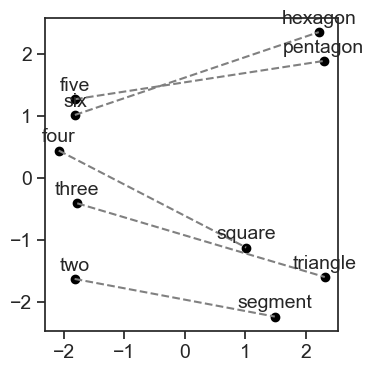

<Figure size 1170x827 with 0 Axes>

In [35]:
# article fig
model, projections = transPCA(vectors, numbers, shapes)
ax = textplot(projections, numbers, shapes, label1=numbersEn, label2=shapesEn, size=14)

fig = plt.gcf()
fig.set_size_inches(figWidth/2, figWidth/2)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)
plt.tight_layout()
# plt.savefig("VisuNumbersShapes.svg", format="svg")
plt.show()
plt.clf()

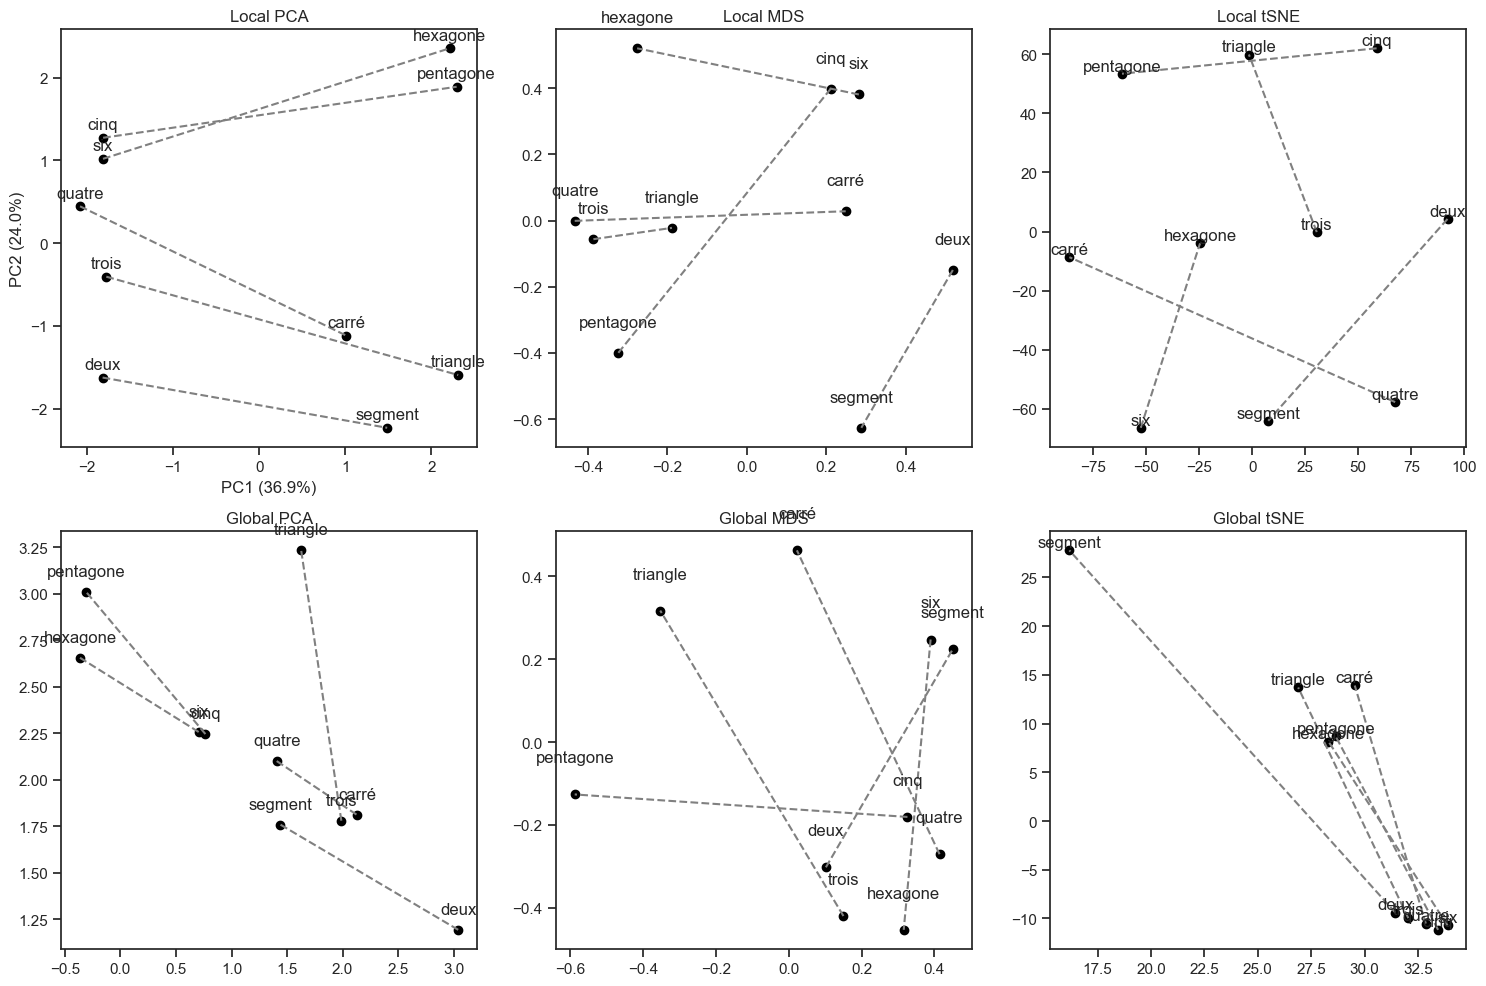

<Figure size 1170x827 with 0 Axes>

In [36]:
analyseDiff(vectors, numbers, shapes)

Intra groups:
               0
count  20.000000
mean    0.557762
std     0.433138
min    -0.226994
25%     0.209125
50%     0.706052
75%     0.935391
max     0.994943


Inter groups:
               0
count  25.000000
mean   -0.627423
std     0.353259
min    -0.999971
25%    -0.931588
50%    -0.715560
75%    -0.354916
max     0.140706


t-test of independence: t(43) = 10.11, p = 6.10e-13 (***)


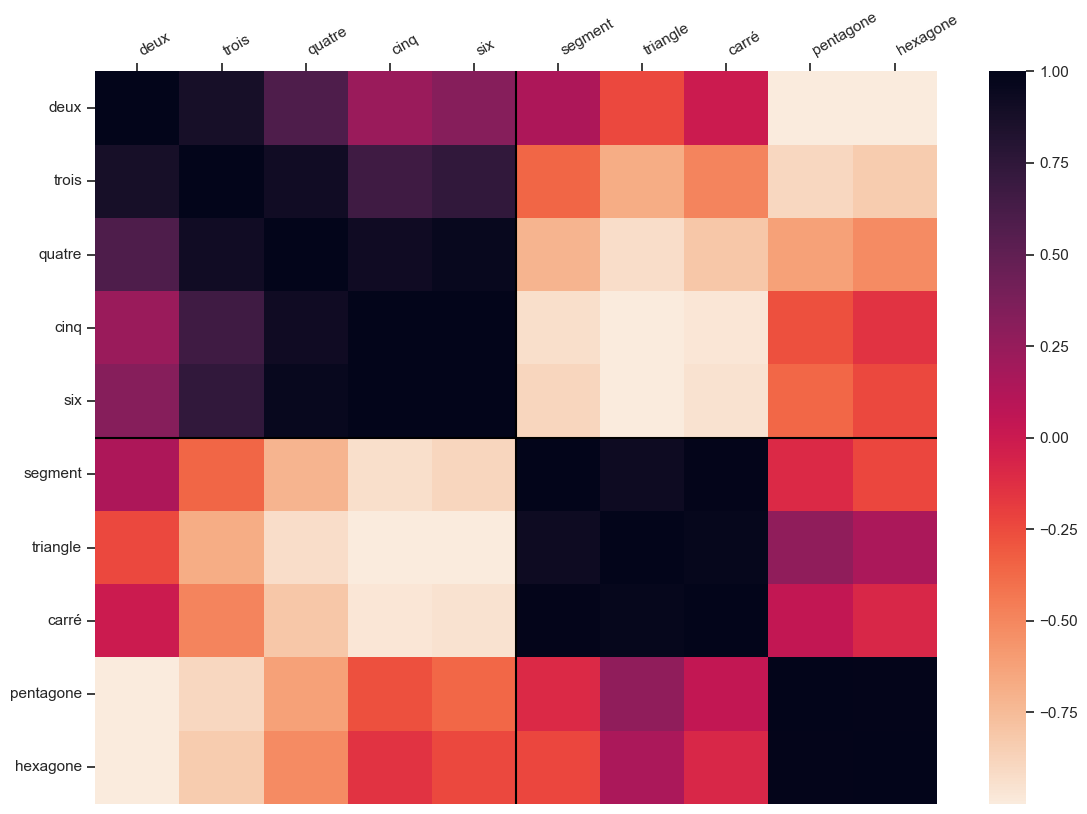

<Axes: >

<Figure size 1170x827 with 0 Axes>

In [37]:
projSimMatrix(vectors, numbers, shapes)

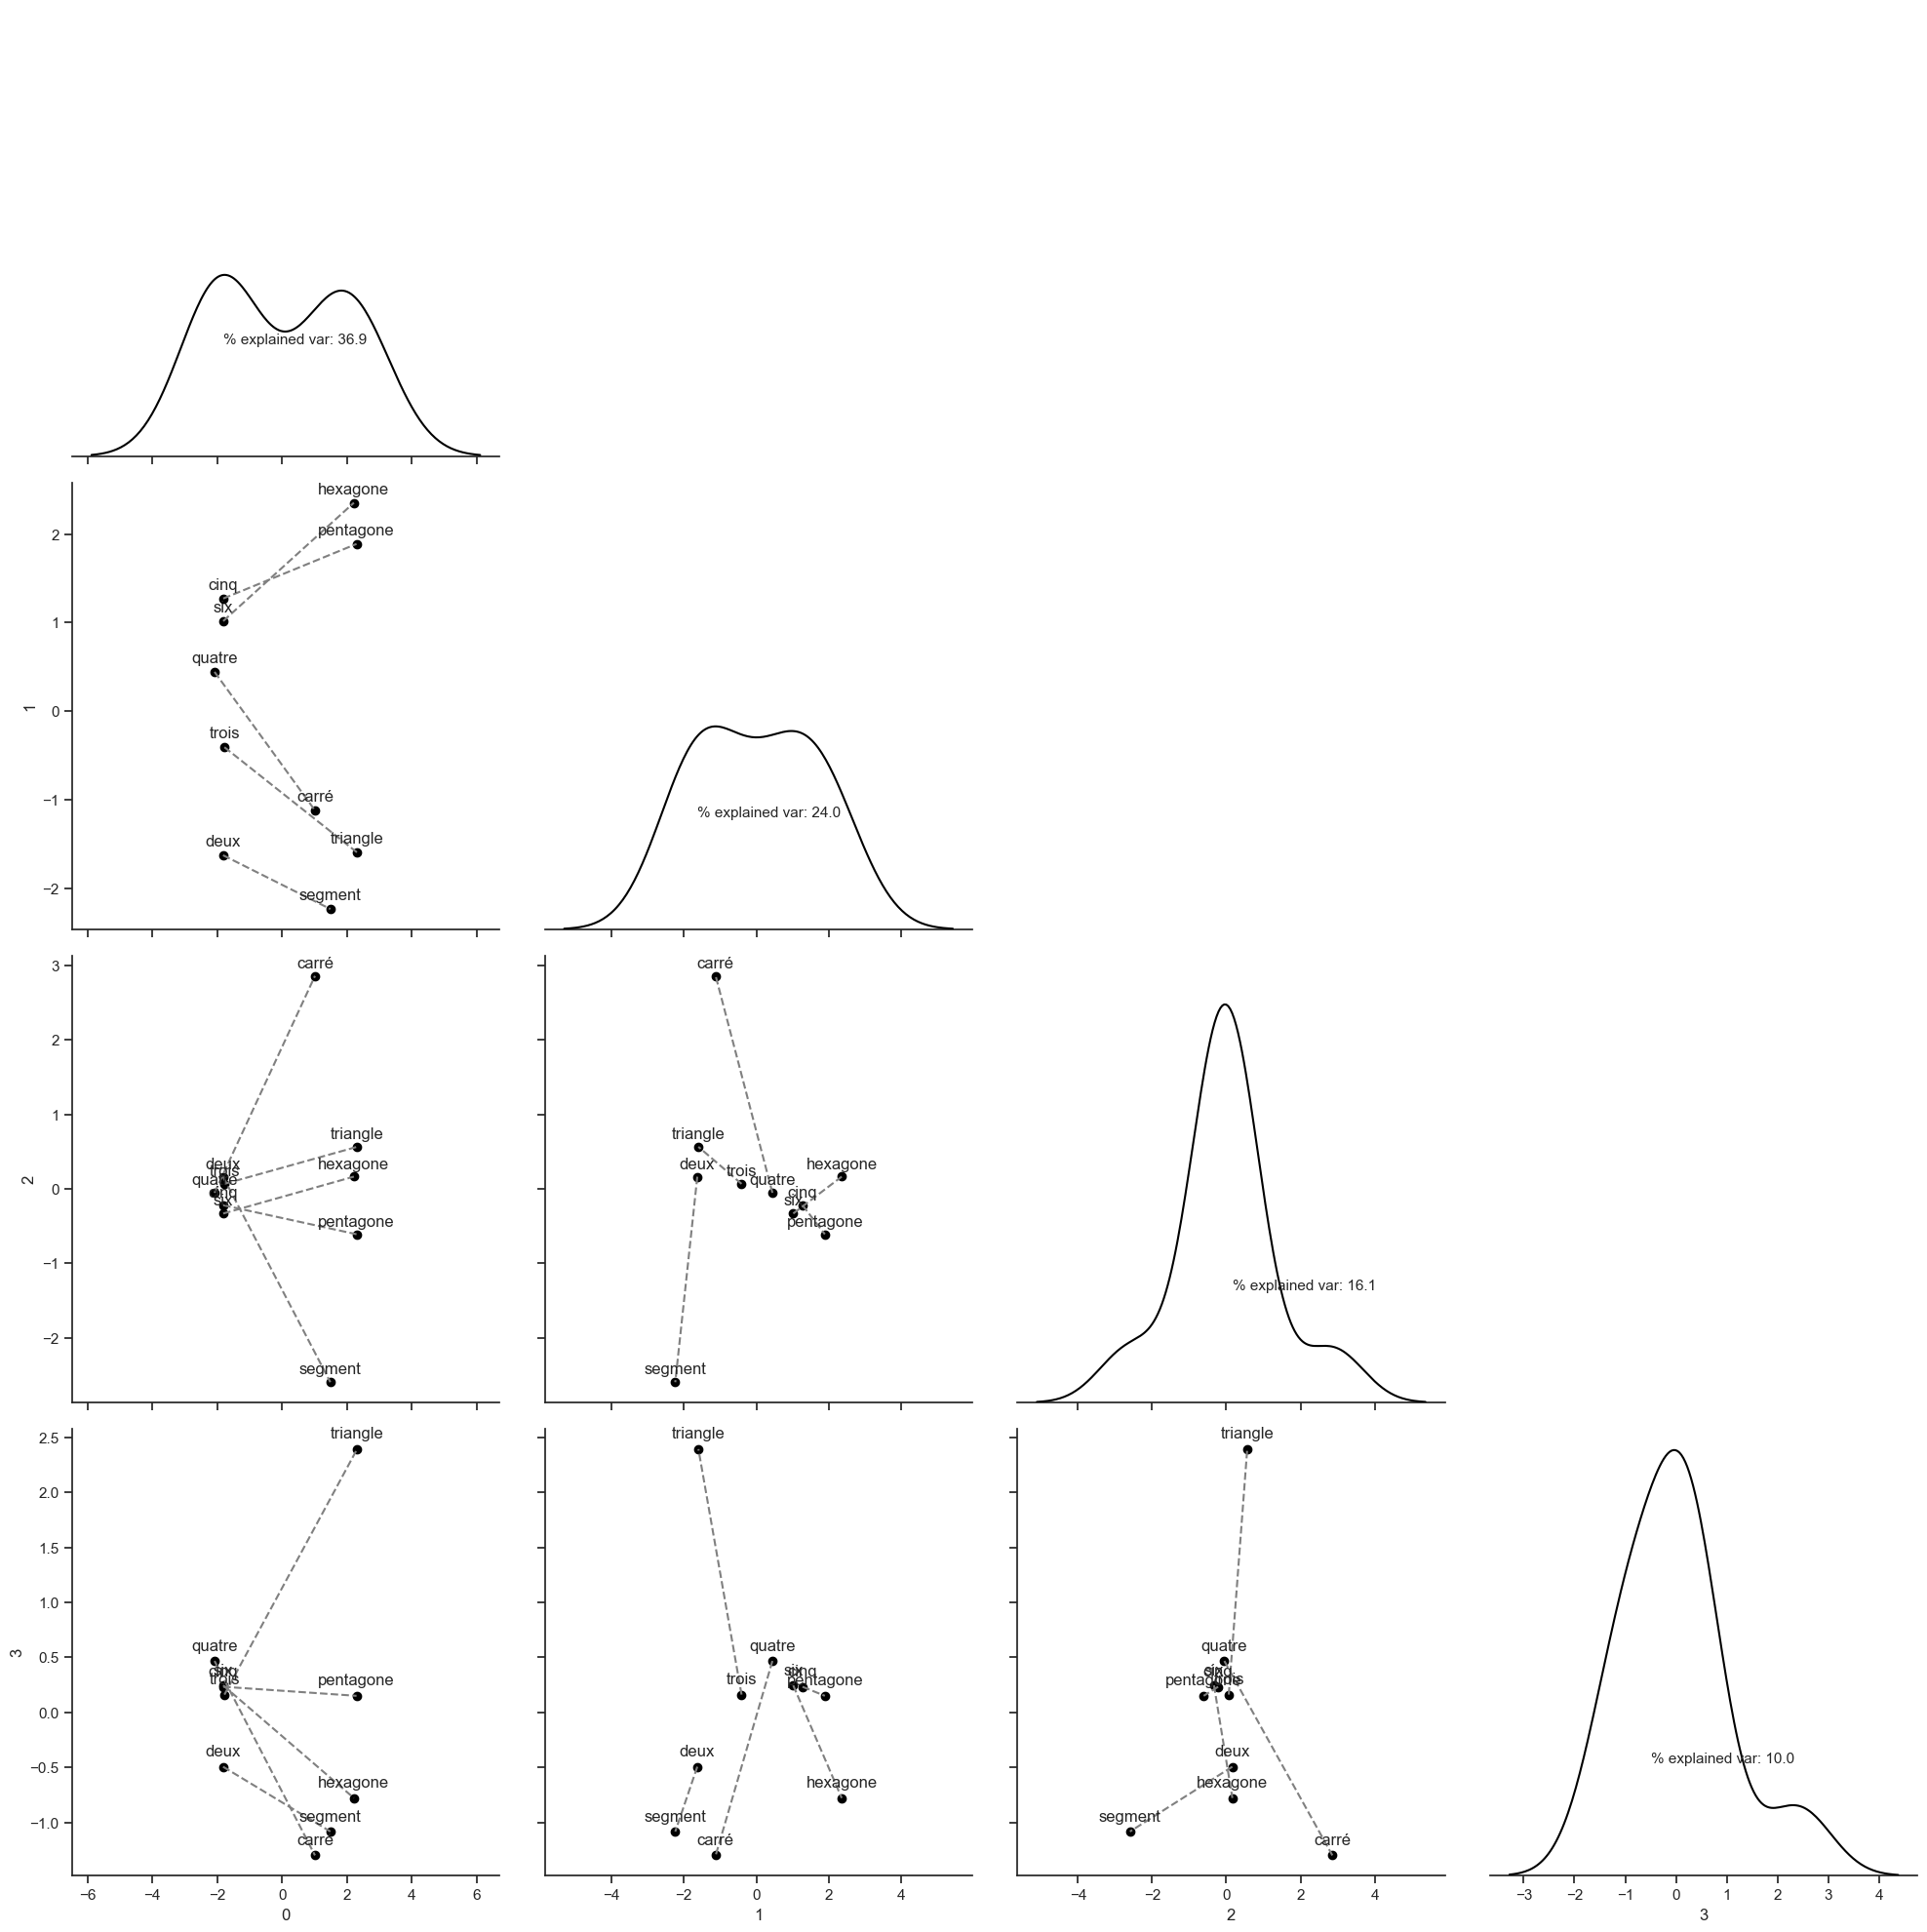

<Figure size 1170x827 with 0 Axes>

In [38]:
PCApairplot(vectors, numbers, shapes)

### Numbers / Fractions

In [39]:
numbers = ['deux', 'trois', 'quatre', 'cinq']
fractions = ['demi', 'tiers', 'quart', 'cinquième']

numbersEn = ['two', 'three', 'four', 'five']
fractionsEn = ['half', 'third', 'fourth', 'fifth']

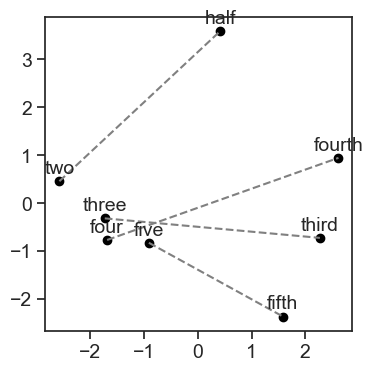

<Figure size 1170x827 with 0 Axes>

In [40]:
# article fig
model, projections = transPCA(vectors, numbers, fractions)
ax = textplot(projections, numbers, fractions, label1=numbersEn, label2=fractionsEn, size=14)

fig = plt.gcf()
fig.set_size_inches(figWidth/2, figWidth/2)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)
plt.tight_layout()
# plt.savefig("VisuNumbersFractions.svg", format="svg")
plt.show()
plt.clf()

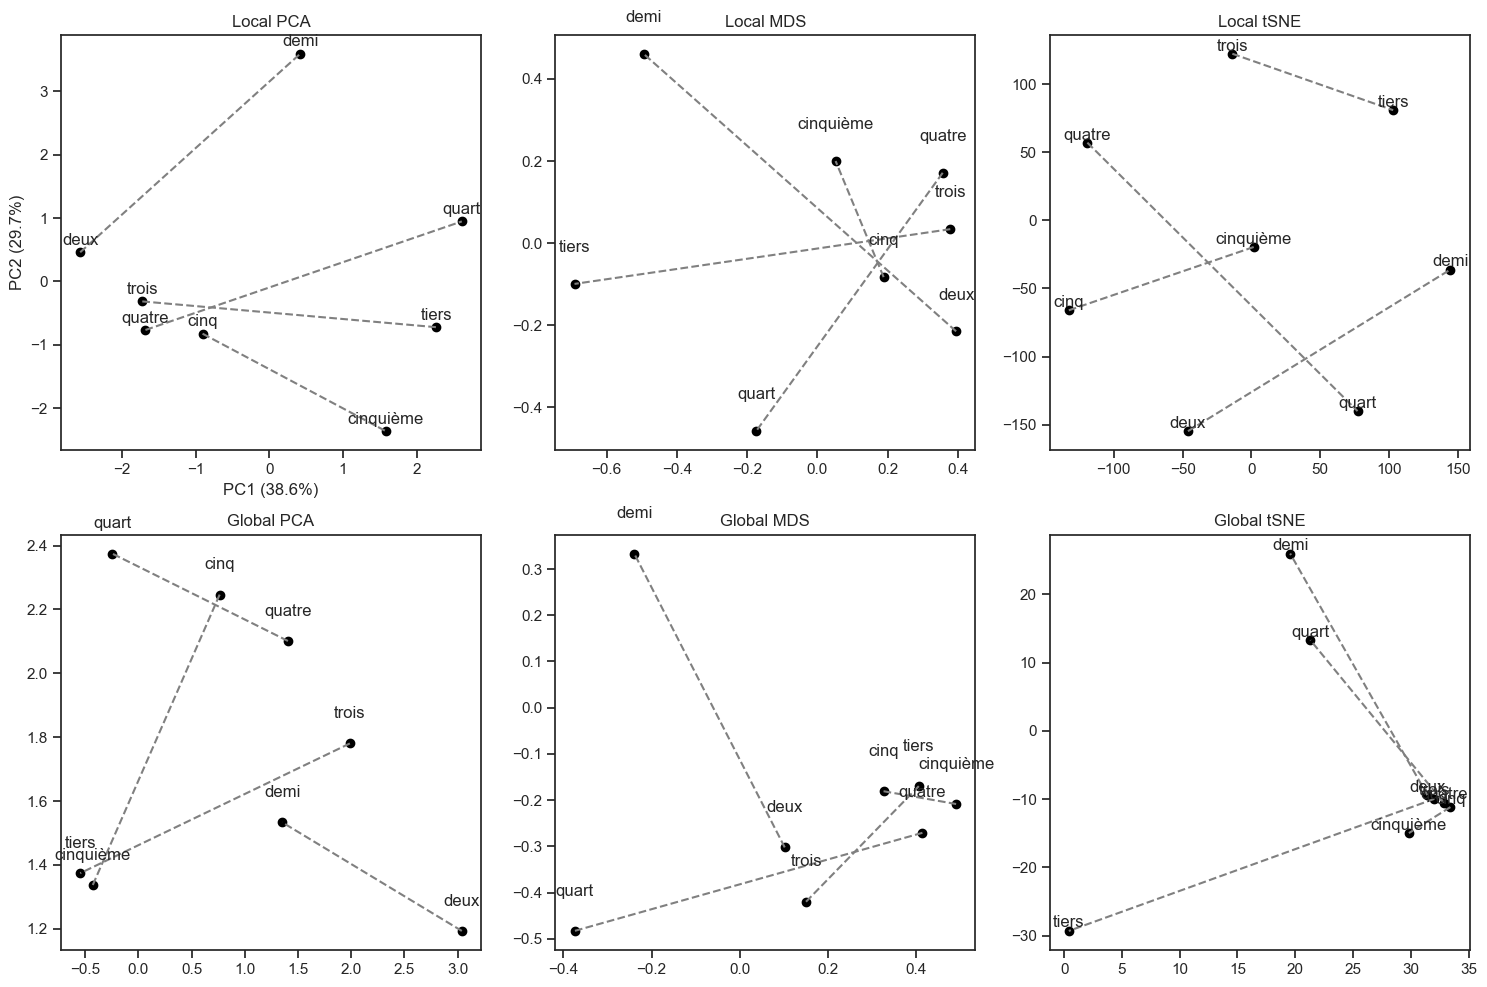

<Figure size 1170x827 with 0 Axes>

In [41]:
analyseDiff(vectors, numbers, fractions)

Intra groups:
               0
count  12.000000
mean    0.537478
std     0.534270
min    -0.760842
25%     0.395347
50%     0.787504
75%     0.870734
max     0.969797


Inter groups:
               0
count  16.000000
mean   -0.593571
std     0.374804
min    -0.996764
25%    -0.892862
50%    -0.717407
75%    -0.371346
max     0.147822


t-test of independence: t(26) = 6.59, p = 5.43e-07 (***)


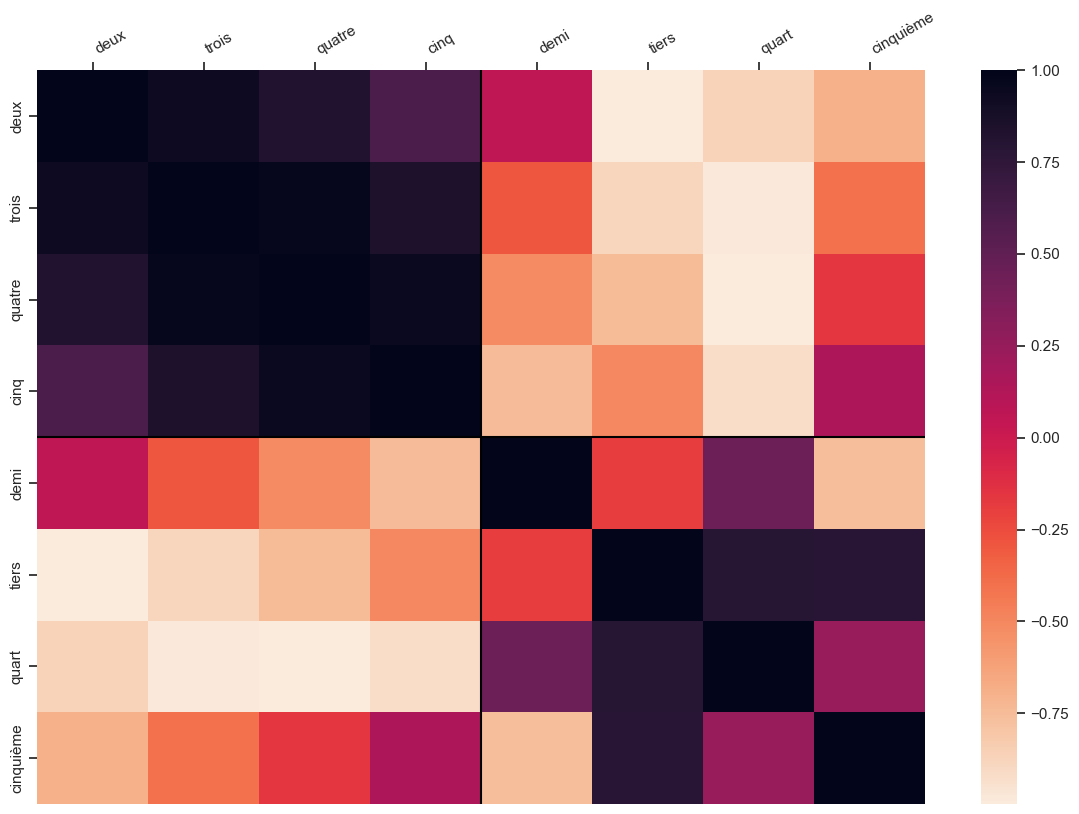

<Axes: >

<Figure size 1170x827 with 0 Axes>

In [42]:
projSimMatrix(vectors, numbers, fractions)

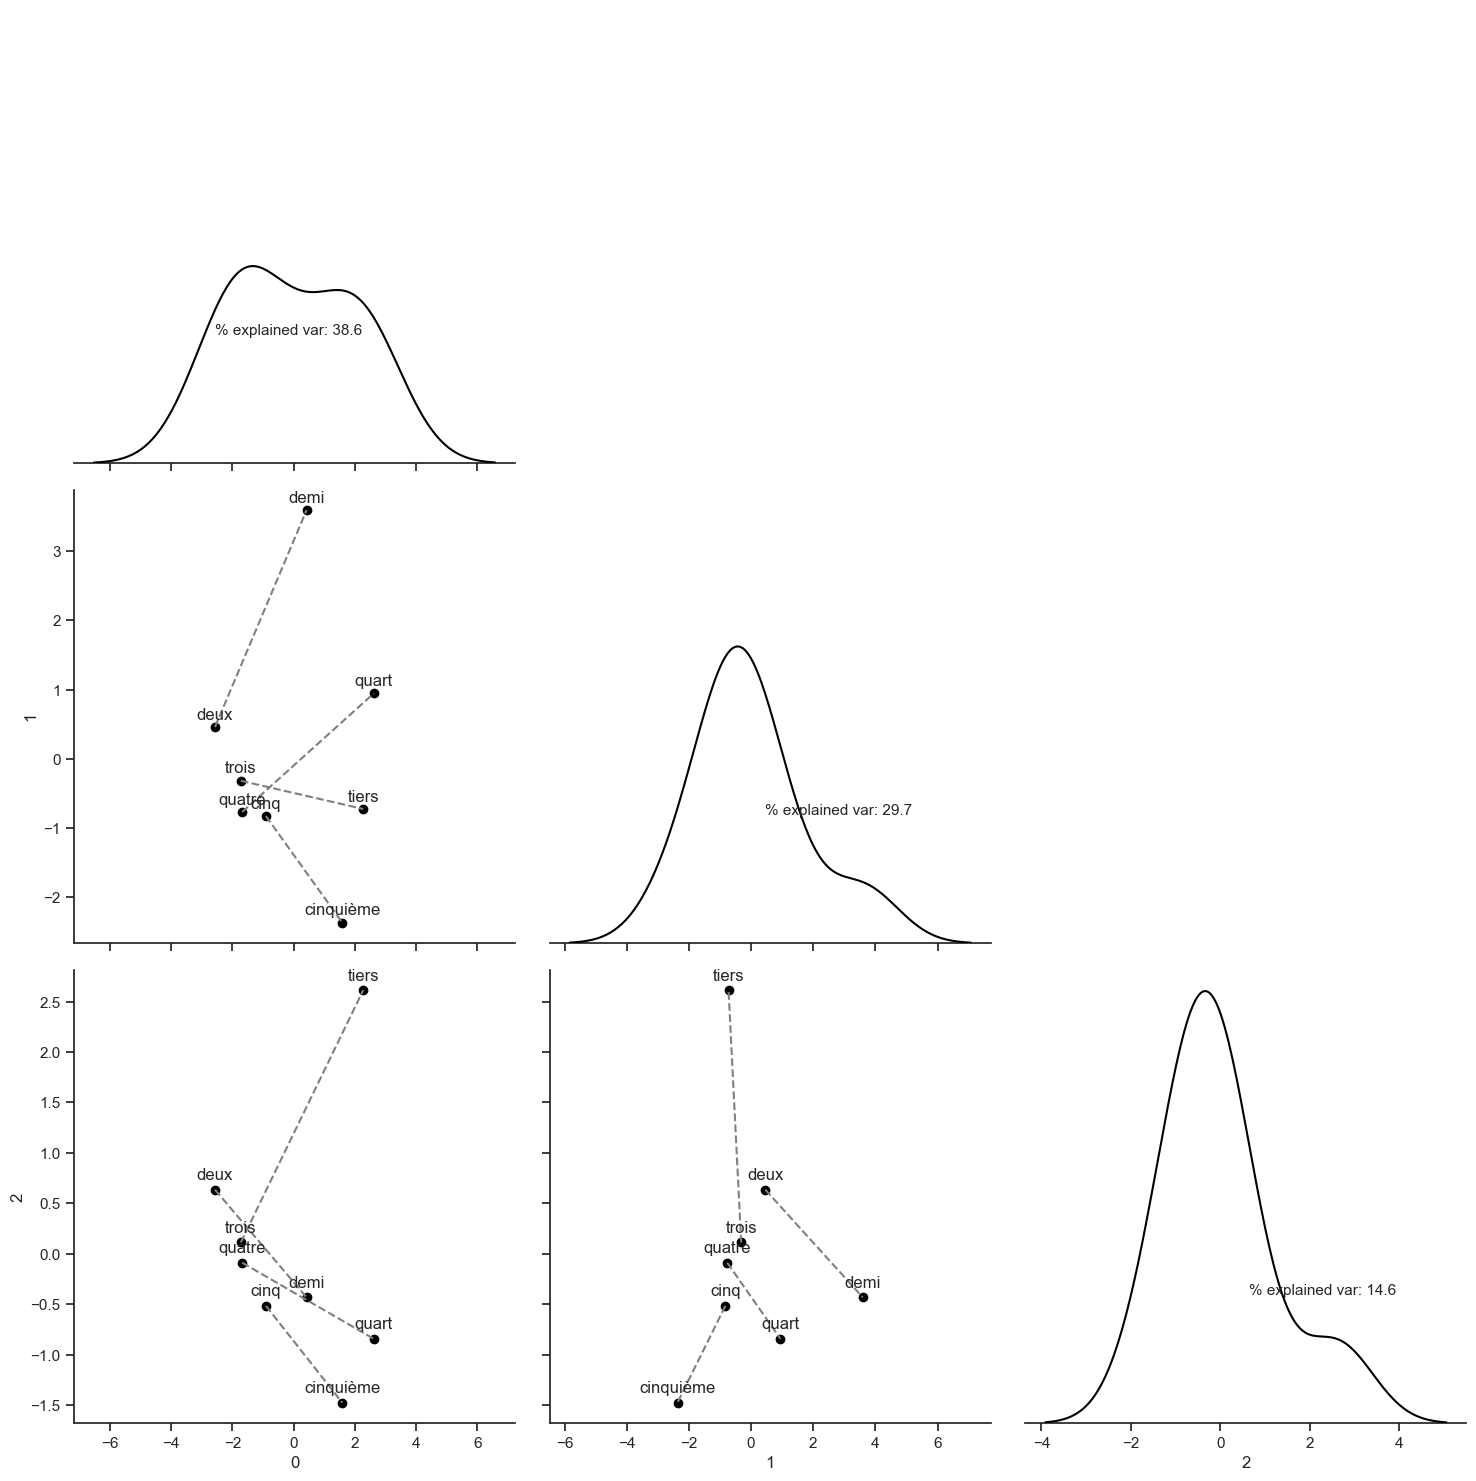

<Figure size 1170x827 with 0 Axes>

In [43]:
PCApairplot(vectors, numbers, fractions)

### Numbers / Ordinals

In [44]:
numbers = ['un', 'deux', 'trois', 'quatre', 'cinq', 'six', 'sept', 'huit', 'neuf']
ordinals = ['premier', 'deuxième', 'troisième', 'quatrième', 'cinquième', 'sixième', 'septième', 'huitième', 'neuvième']

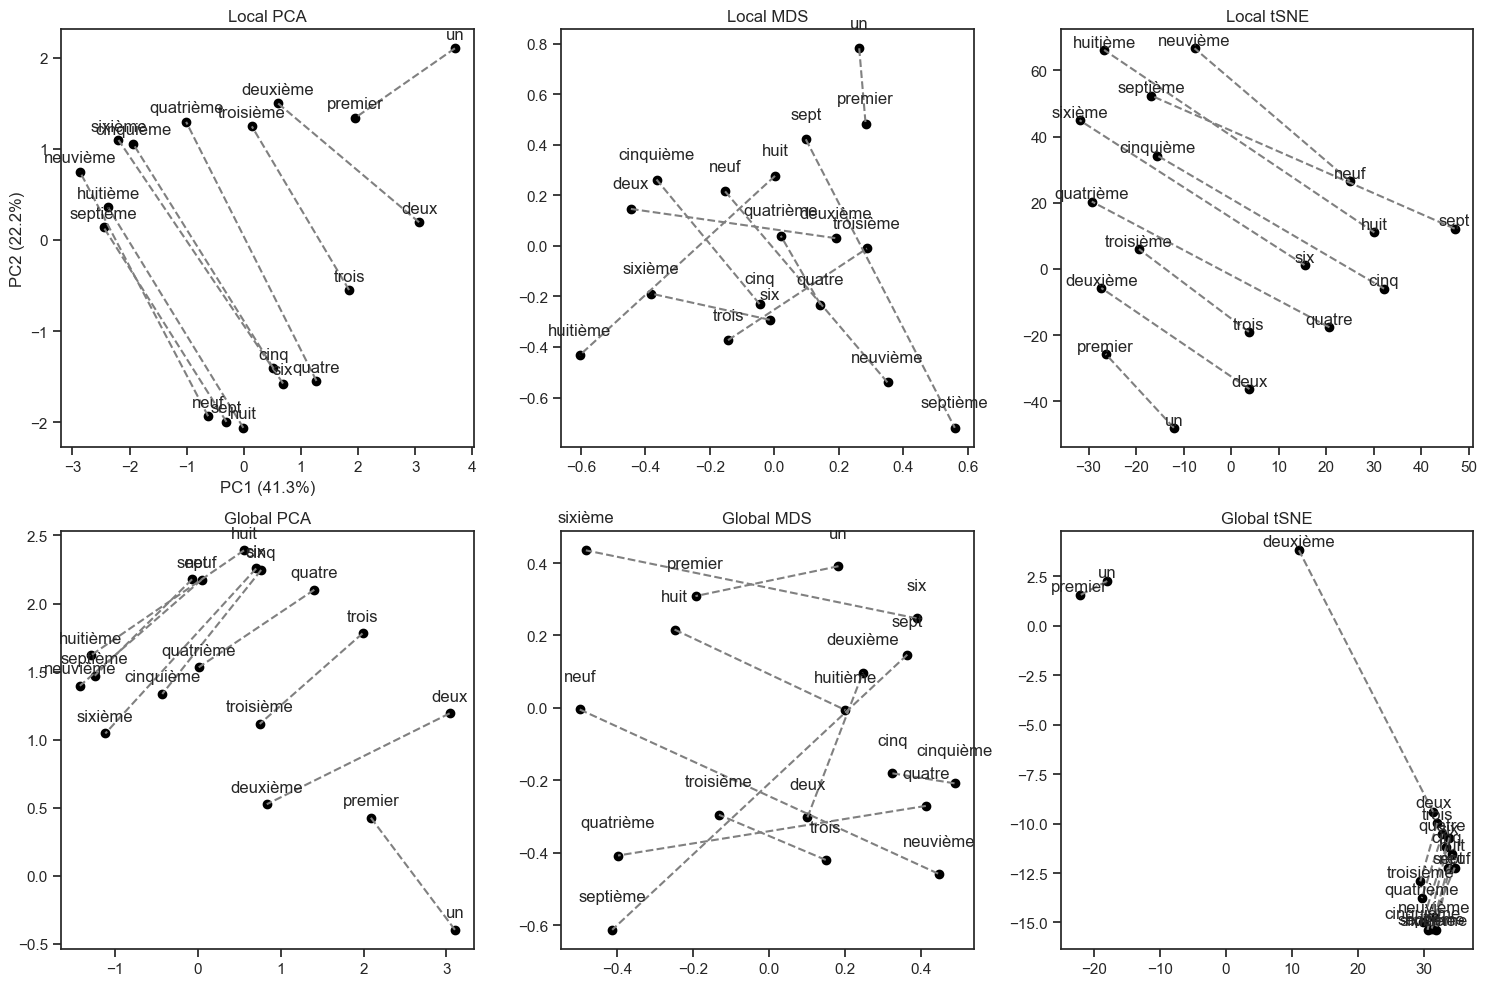

<Figure size 1170x827 with 0 Axes>

In [45]:
analyseDiff(vectors, numbers, ordinals)

Intra groups:
               0
count  72.000000
mean    0.430910
std     0.551135
min    -0.790590
25%    -0.030608
50%     0.656901
75%     0.917333
max     0.999388


Inter groups:
               0
count  81.000000
mean   -0.491125
std     0.491976
min    -0.999664
25%    -0.865993
50%    -0.677712
75%    -0.185216
max     0.996404


t-test of independence: t(151) = 10.93, p = 7.30e-21 (***)


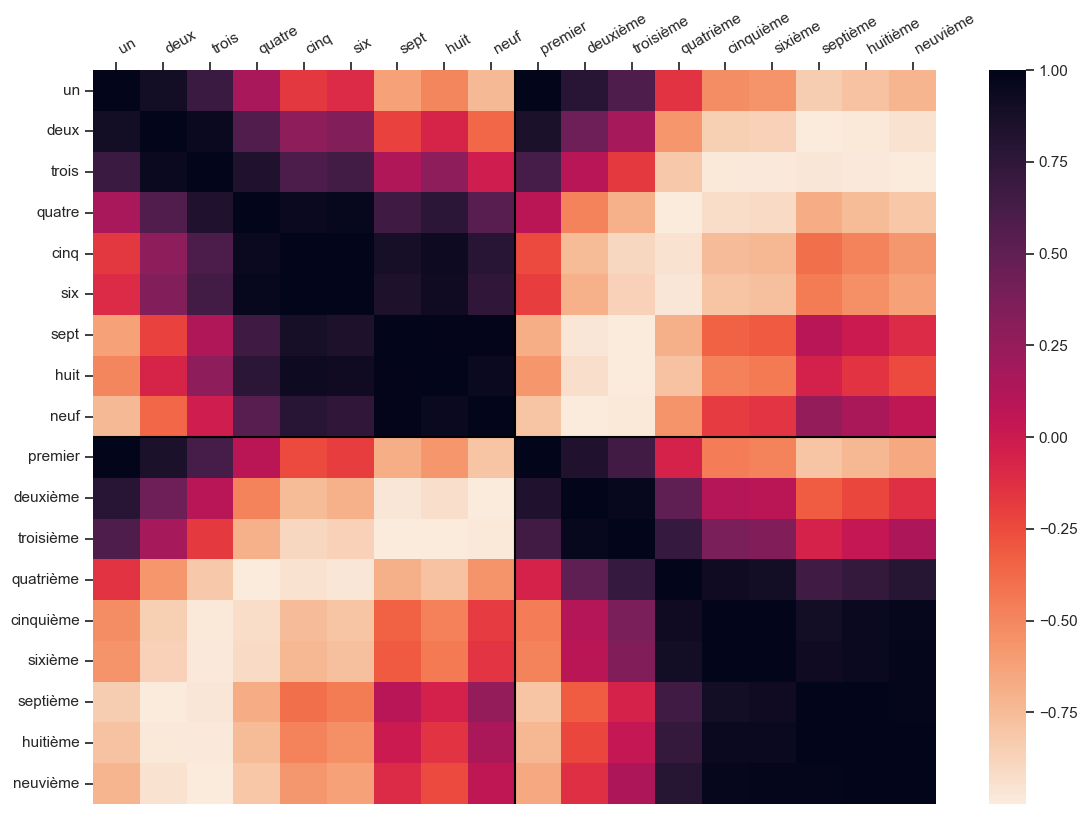

<Axes: >

<Figure size 1170x827 with 0 Axes>

In [46]:
projSimMatrix(vectors, numbers, ordinals)

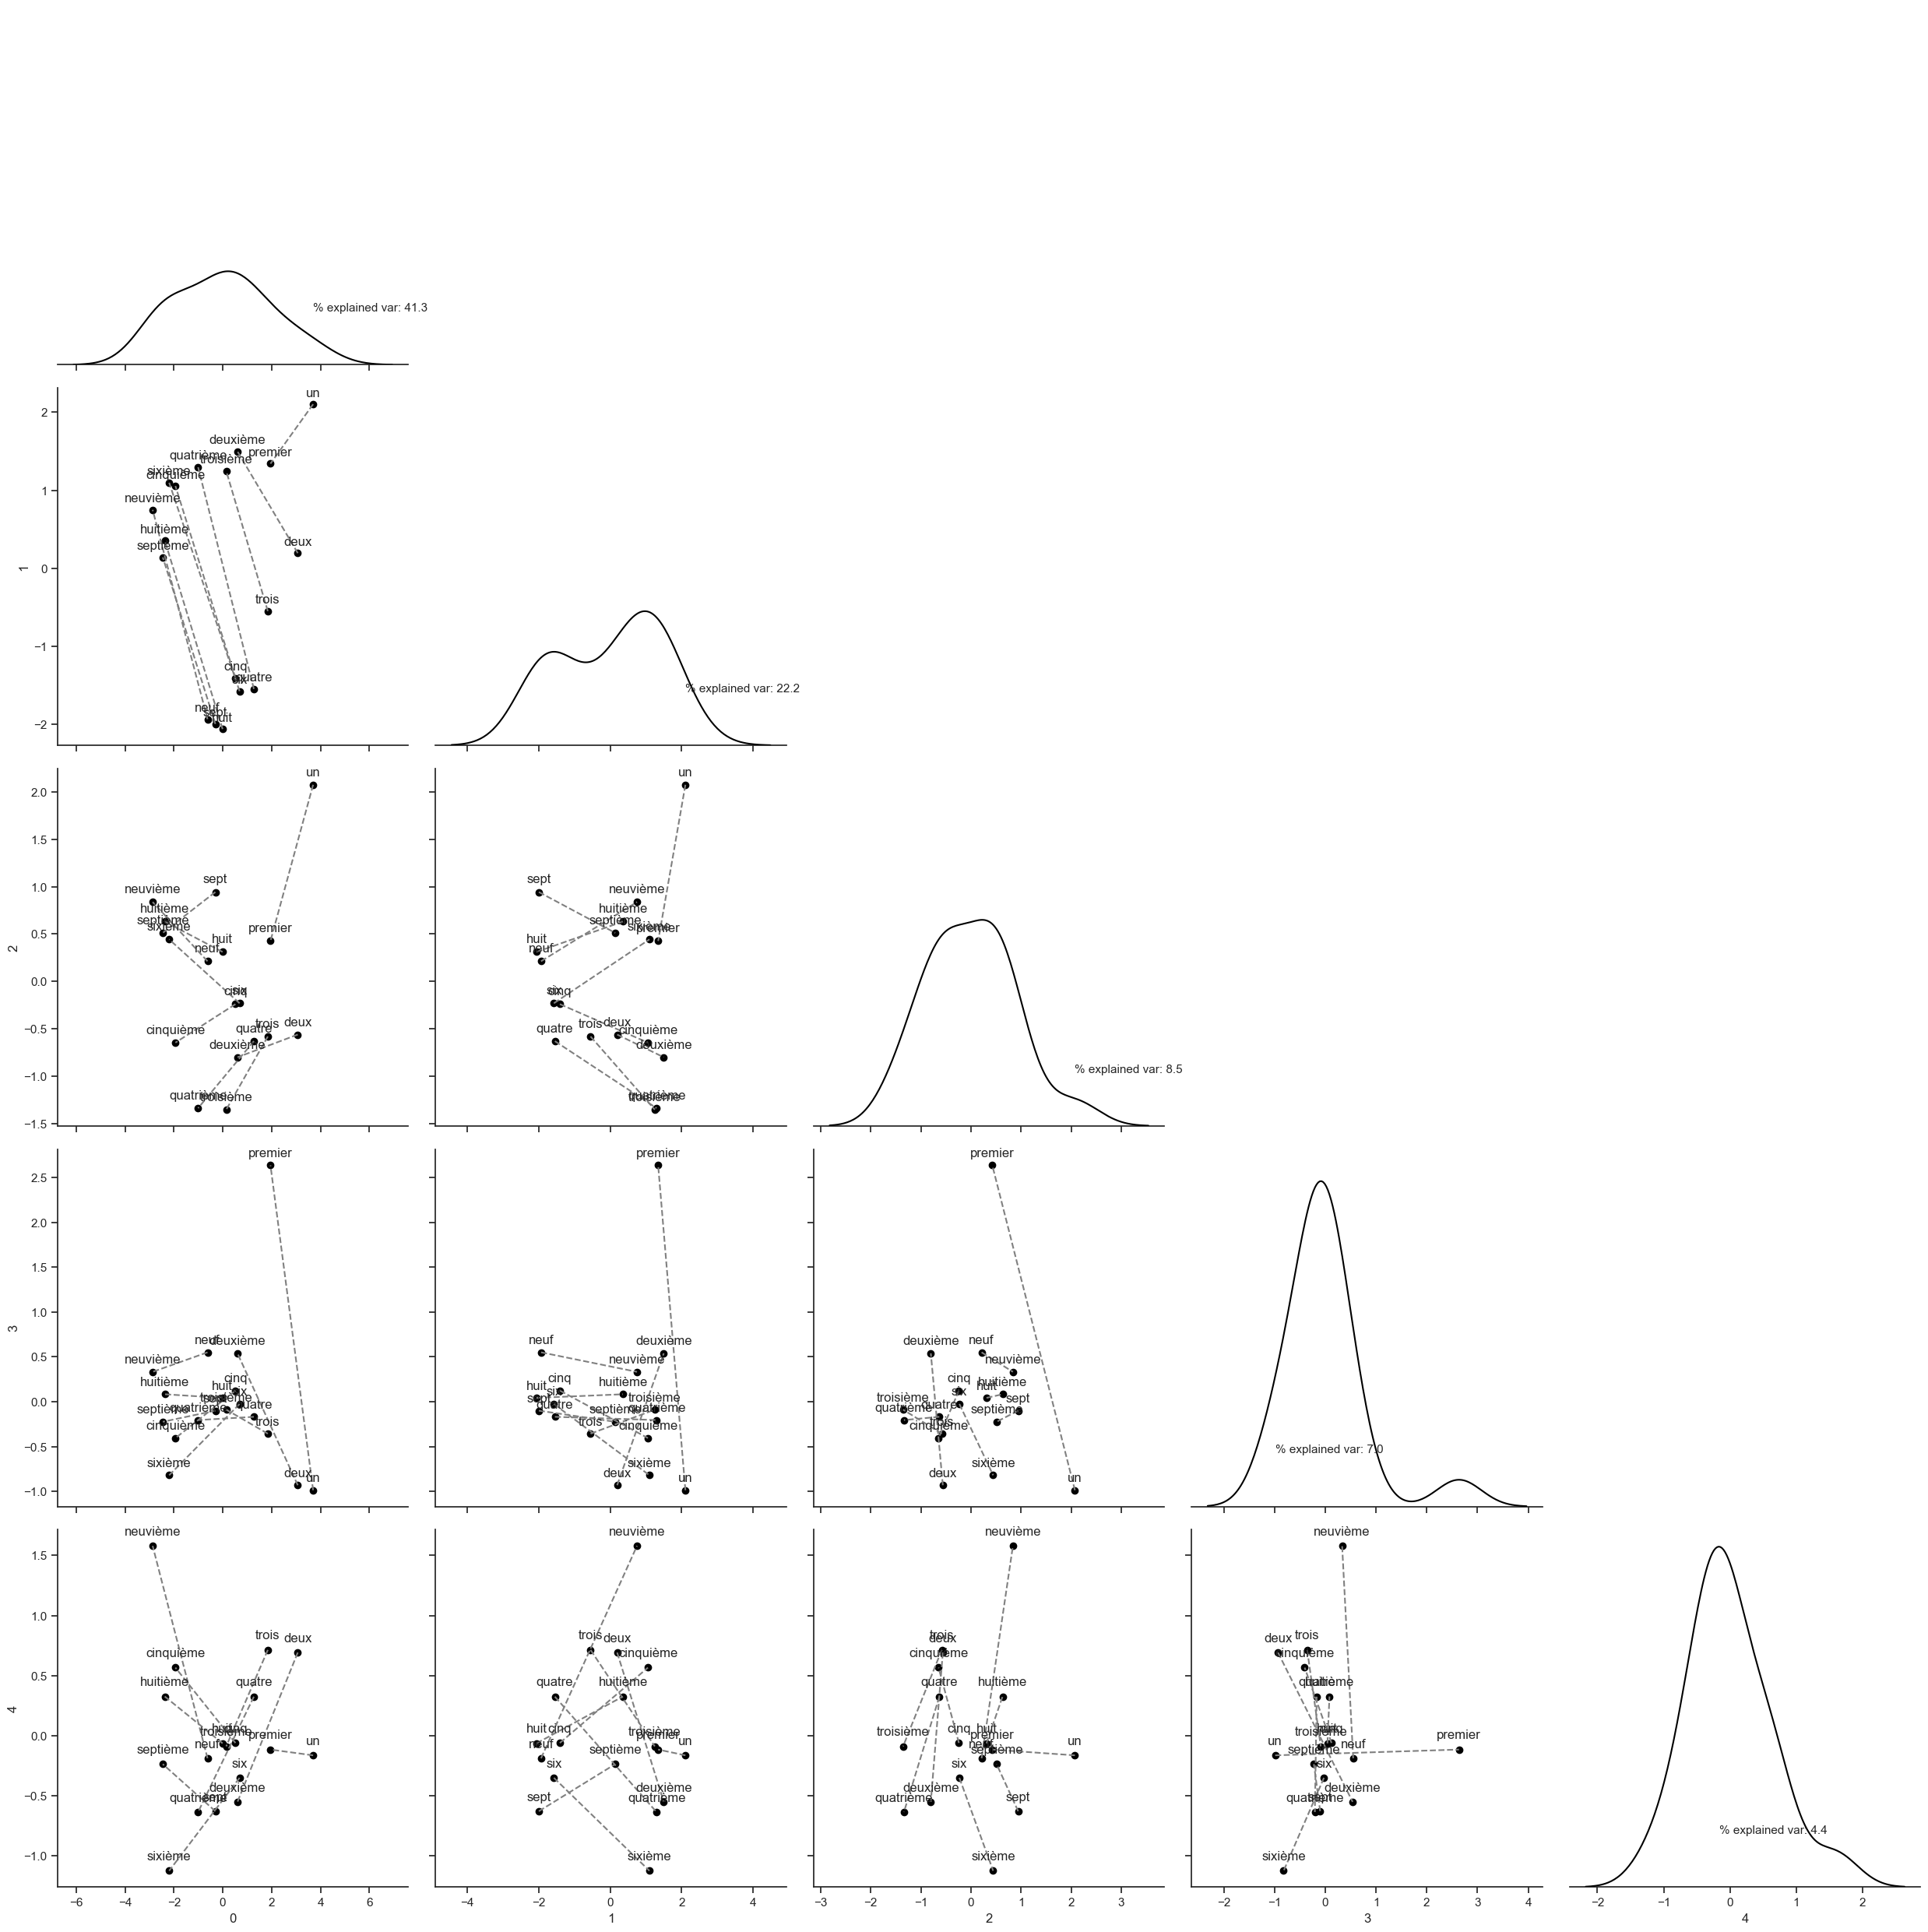

<Figure size 1170x827 with 0 Axes>

In [47]:
PCApairplot(vectors, numbers, ordinals)

### Numbers / Powers of ten

In [48]:
numbers = [ 'un', 'deux', 'trois', 'six', 'neuf']
powers = ['dix', 'cent', 'mille', 'million', 'milliard']

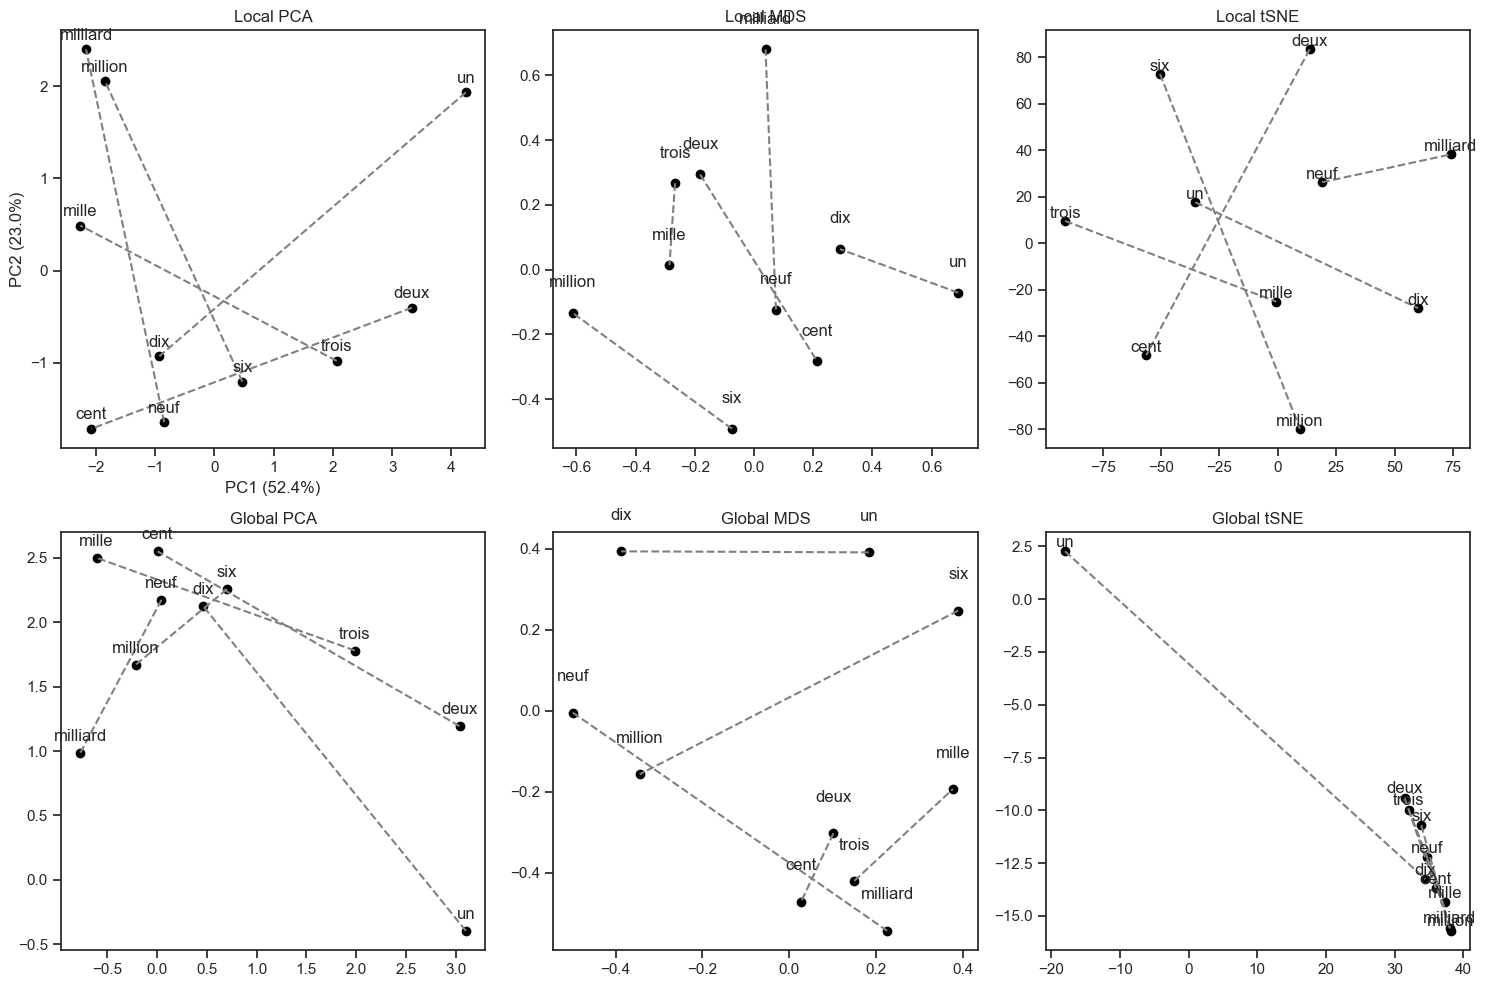

<Figure size 1170x827 with 0 Axes>

In [49]:
analyseDiff(vectors, numbers, powers)

Intra groups:
               0
count  20.000000
mean    0.392064
std     0.507412
min    -0.785043
25%    -0.037223
50%     0.579446
75%     0.810431
max     0.999998


Inter groups:
               0
count  25.000000
mean   -0.439194
std     0.581702
min    -0.995673
25%    -0.923288
50%    -0.616271
75%    -0.300907
max     0.952634


t-test of independence: t(43) = 5.04, p = 8.97e-06 (***)


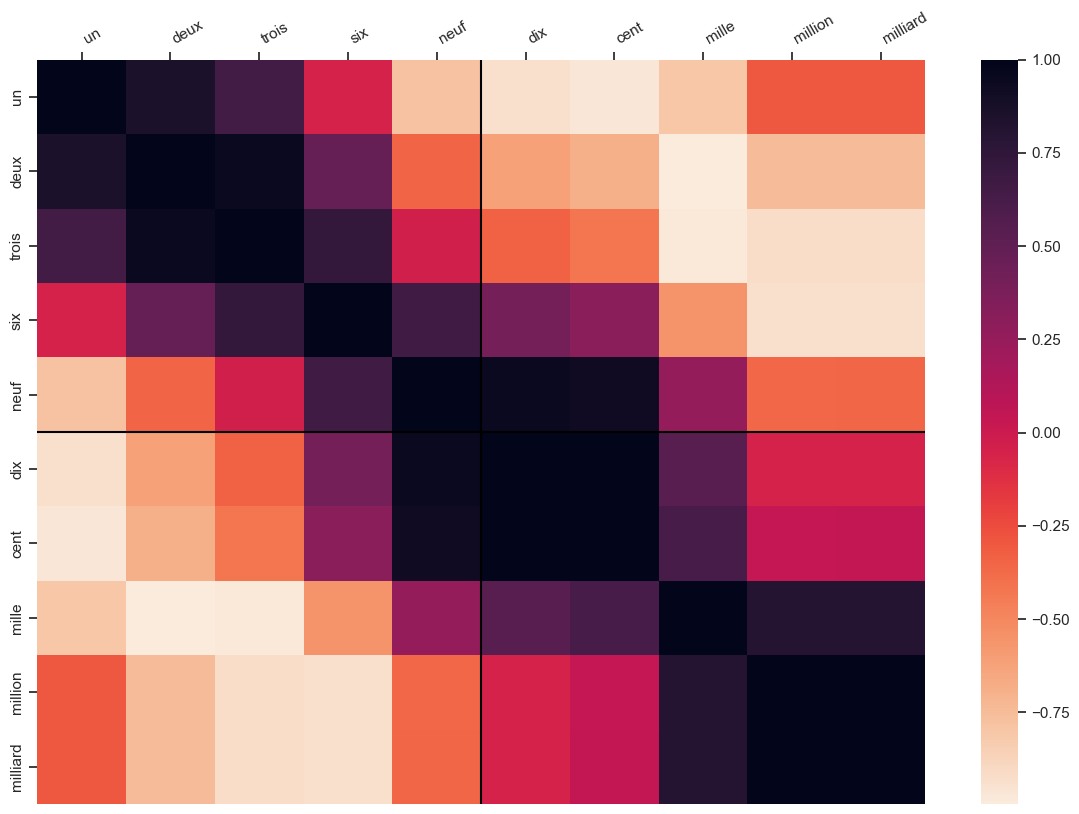

<Axes: >

<Figure size 1170x827 with 0 Axes>

In [50]:
projSimMatrix(vectors, numbers, powers)

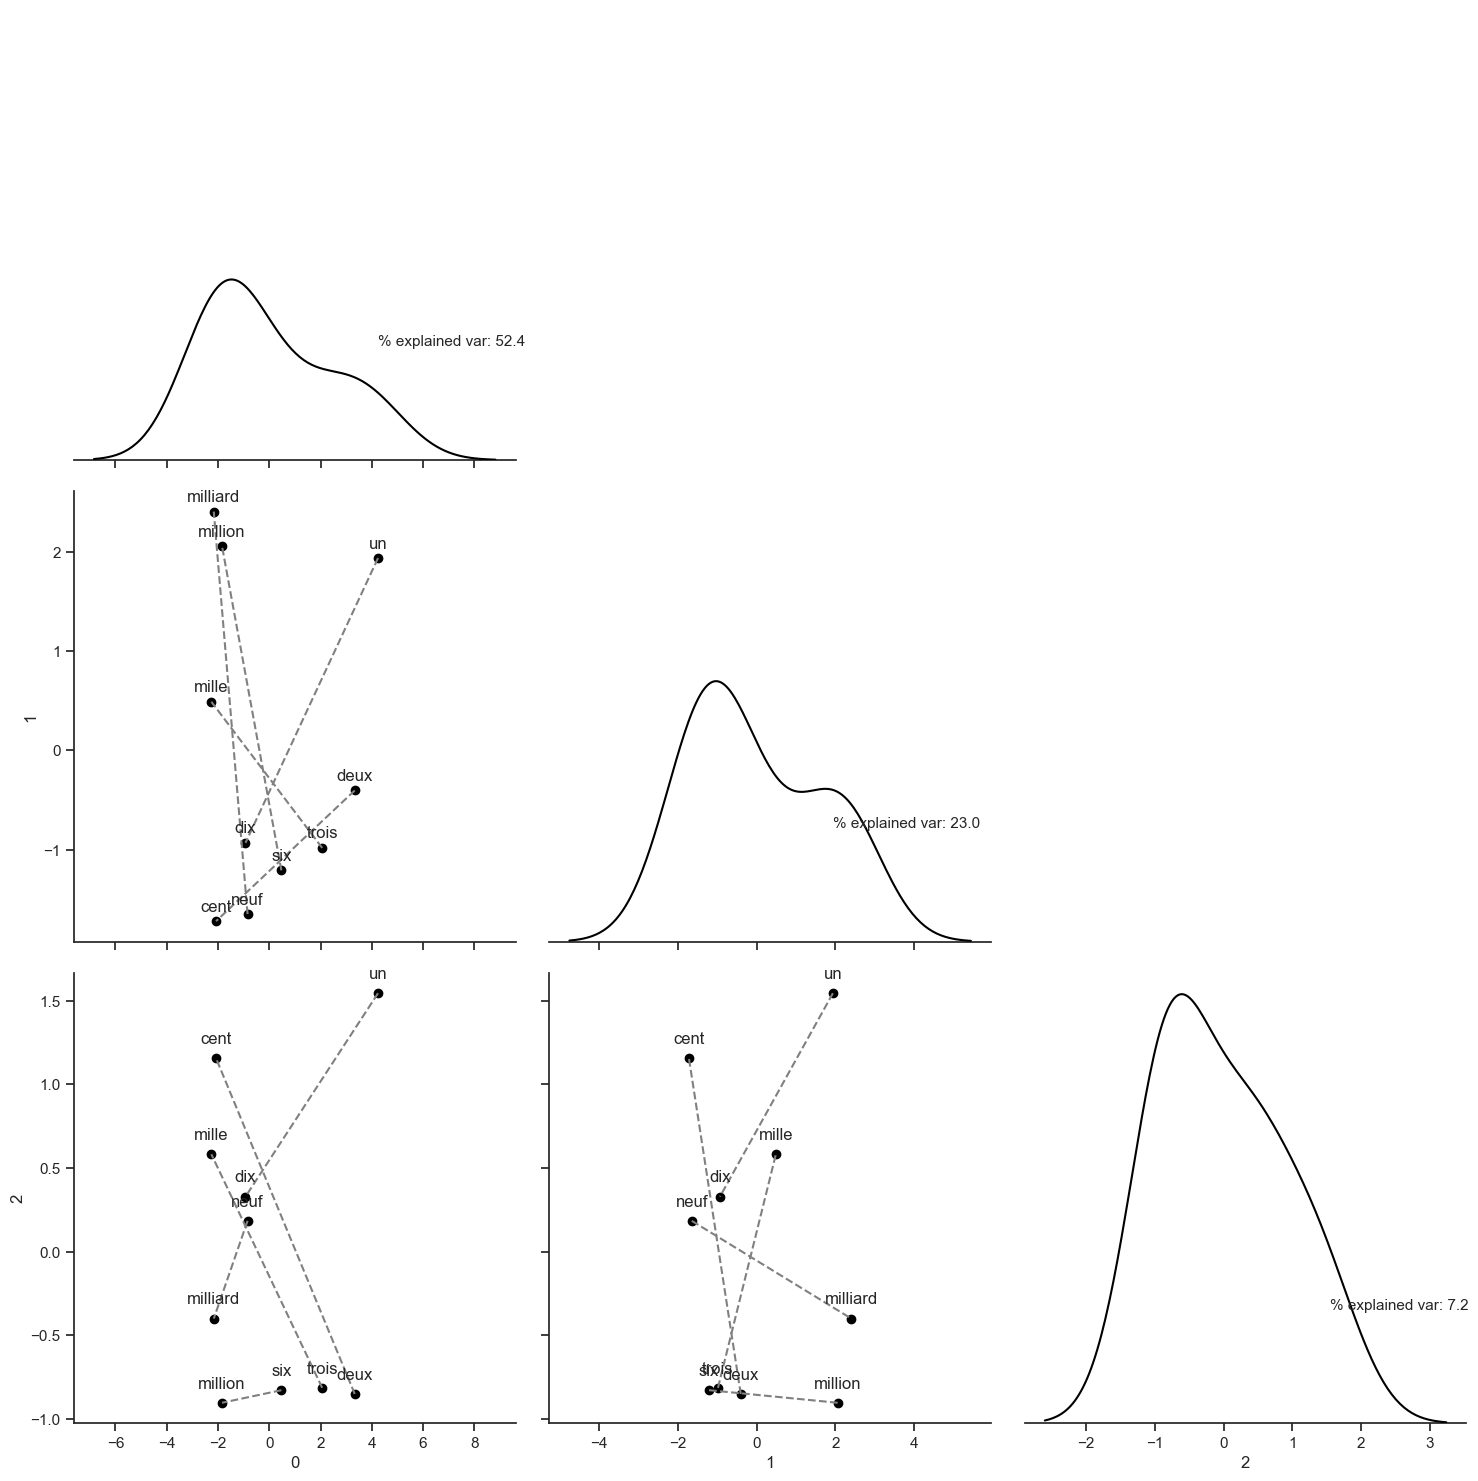

<Figure size 1170x827 with 0 Axes>

In [51]:
PCApairplot(vectors, numbers, powers)

### Shapes in 2D / 3D

In [52]:
twoD = ['carré', 'cercle', 'triangle', 'ellipse']
threeD = ['cube', 'sphère', 'pyramide', 'ellipsoïde']

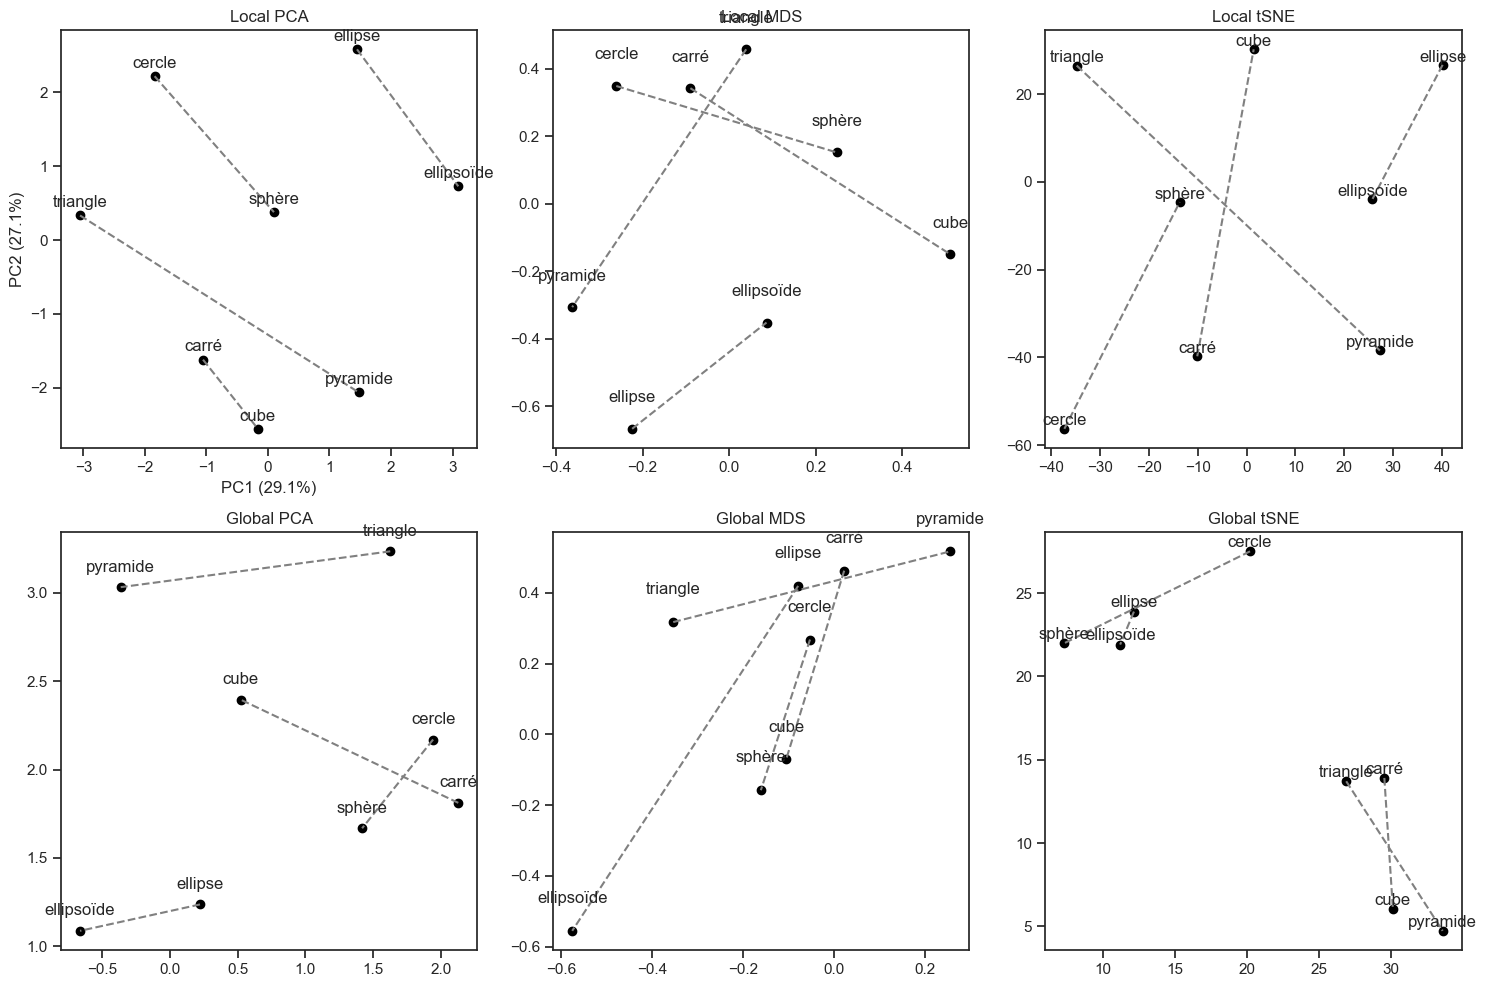

<Figure size 1170x827 with 0 Axes>

In [53]:
analyseDiff(vectors, twoD, threeD)

Intra groups:
               0
count  12.000000
mean   -0.037663
std     0.638948
min    -0.997753
25%    -0.453913
50%     0.034322
75%     0.455039
max     0.774369


Inter groups:
               0
count  16.000000
mean   -0.218877
std     0.700090
min    -0.997446
25%    -0.770892
50%    -0.435230
75%     0.419238
max     0.966786


t-test of independence: t(26) = 0.70, p = 4.88e-01


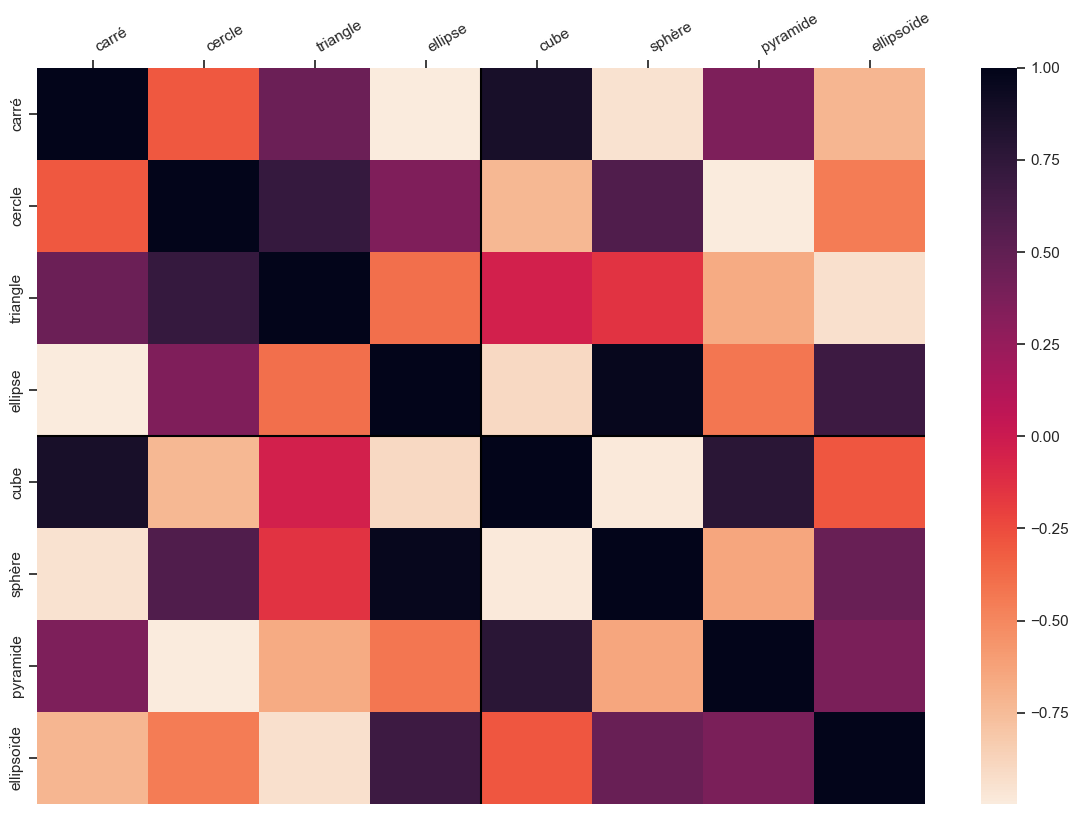

<Axes: >

<Figure size 1170x827 with 0 Axes>

In [54]:
projSimMatrix(vectors, twoD, threeD)

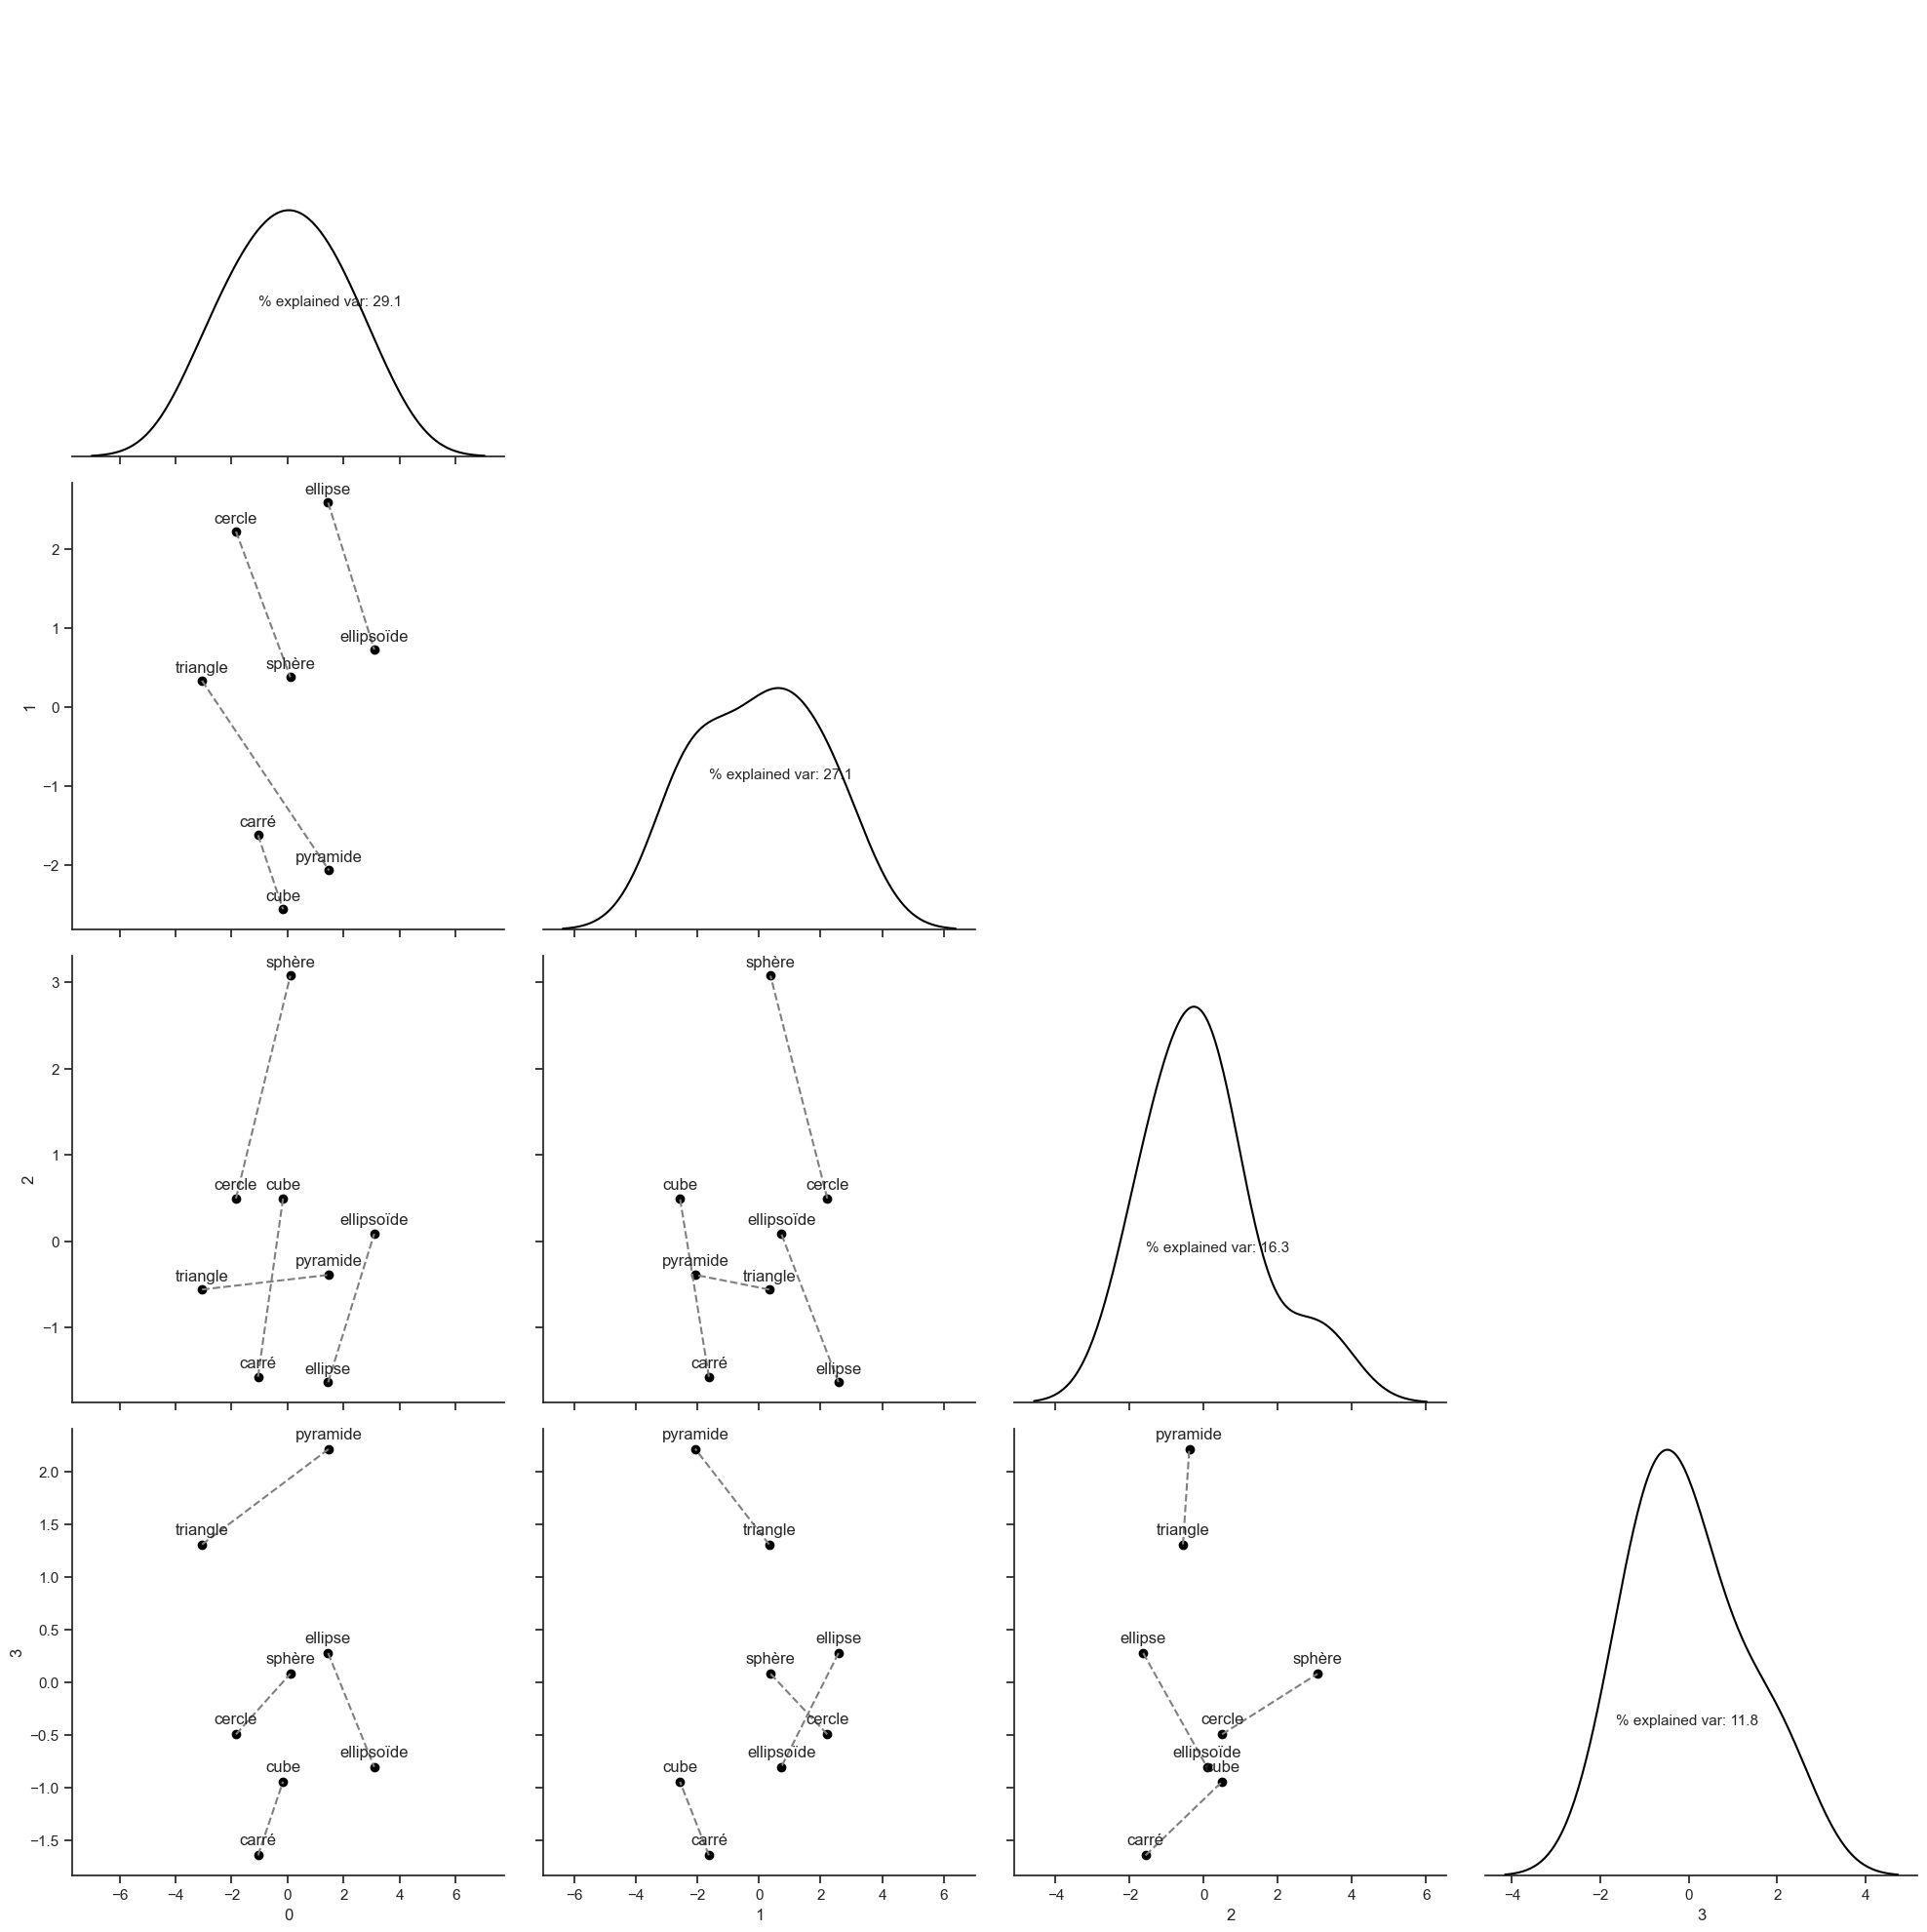

<Figure size 1170x827 with 0 Axes>

In [55]:
PCApairplot(vectors, twoD, threeD)

### Operations / Inverse

In [56]:
directOperations = ['addition', 'multiplication', 'carré', 'exponentielle']
reverseOperations = ['soustraction', 'division', 'racine', 'logarithme']

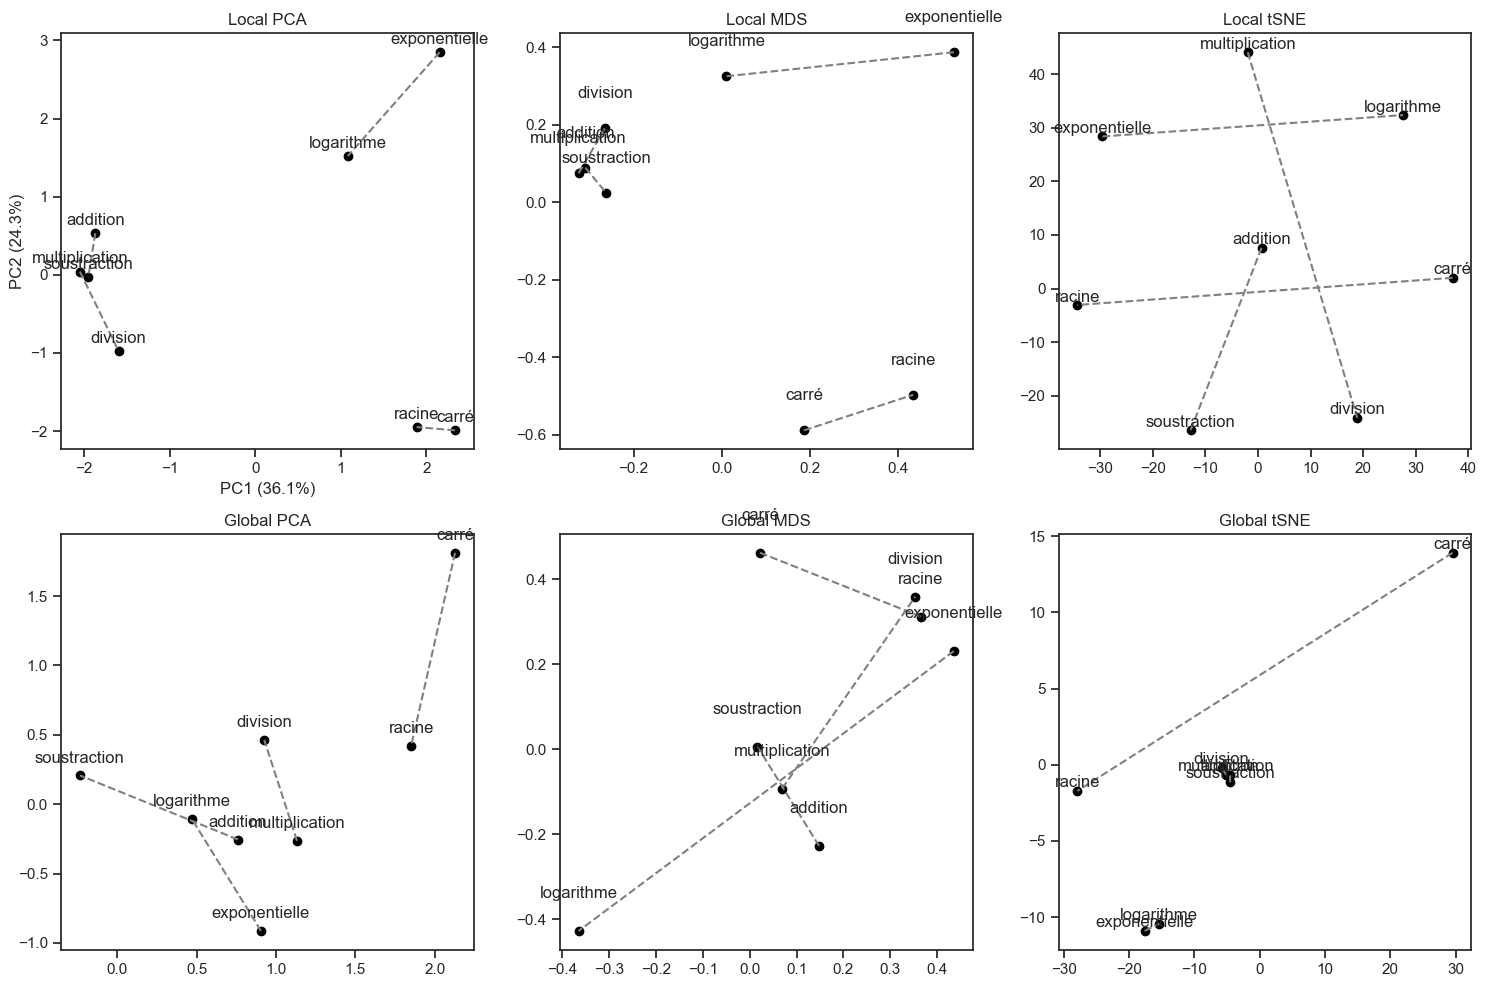

<Figure size 1170x827 with 0 Axes>

In [57]:
analyseDiff(vectors, directOperations, reverseOperations)

Intra groups:
               0
count  12.000000
mean   -0.288223
std     0.627283
min    -0.920271
25%    -0.706722
50%    -0.473581
75%    -0.151656
max     0.966810


Inter groups:
               0
count  16.000000
mean    0.009264
std     0.760966
min    -0.931305
25%    -0.638863
50%    -0.231450
75%     0.870328
max     0.999574


t-test of independence: t(26) = -1.10, p = 2.81e-01


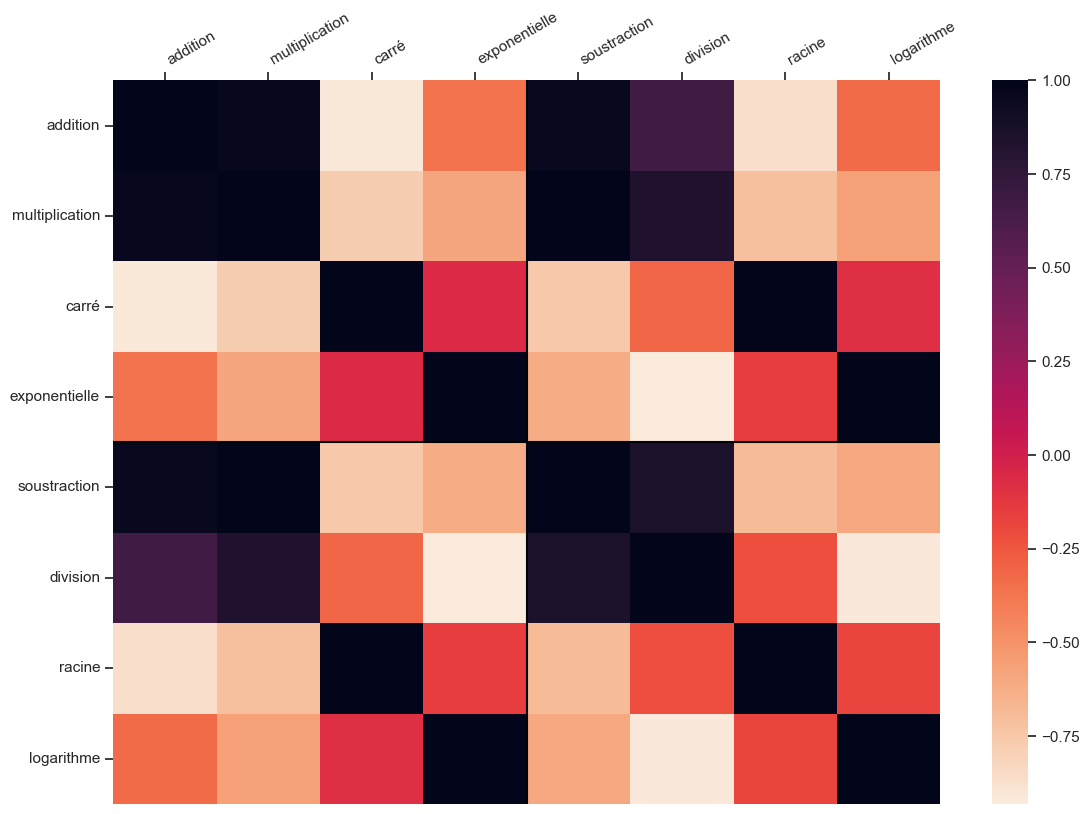

<Axes: >

<Figure size 1170x827 with 0 Axes>

In [58]:
projSimMatrix(vectors, directOperations, reverseOperations)

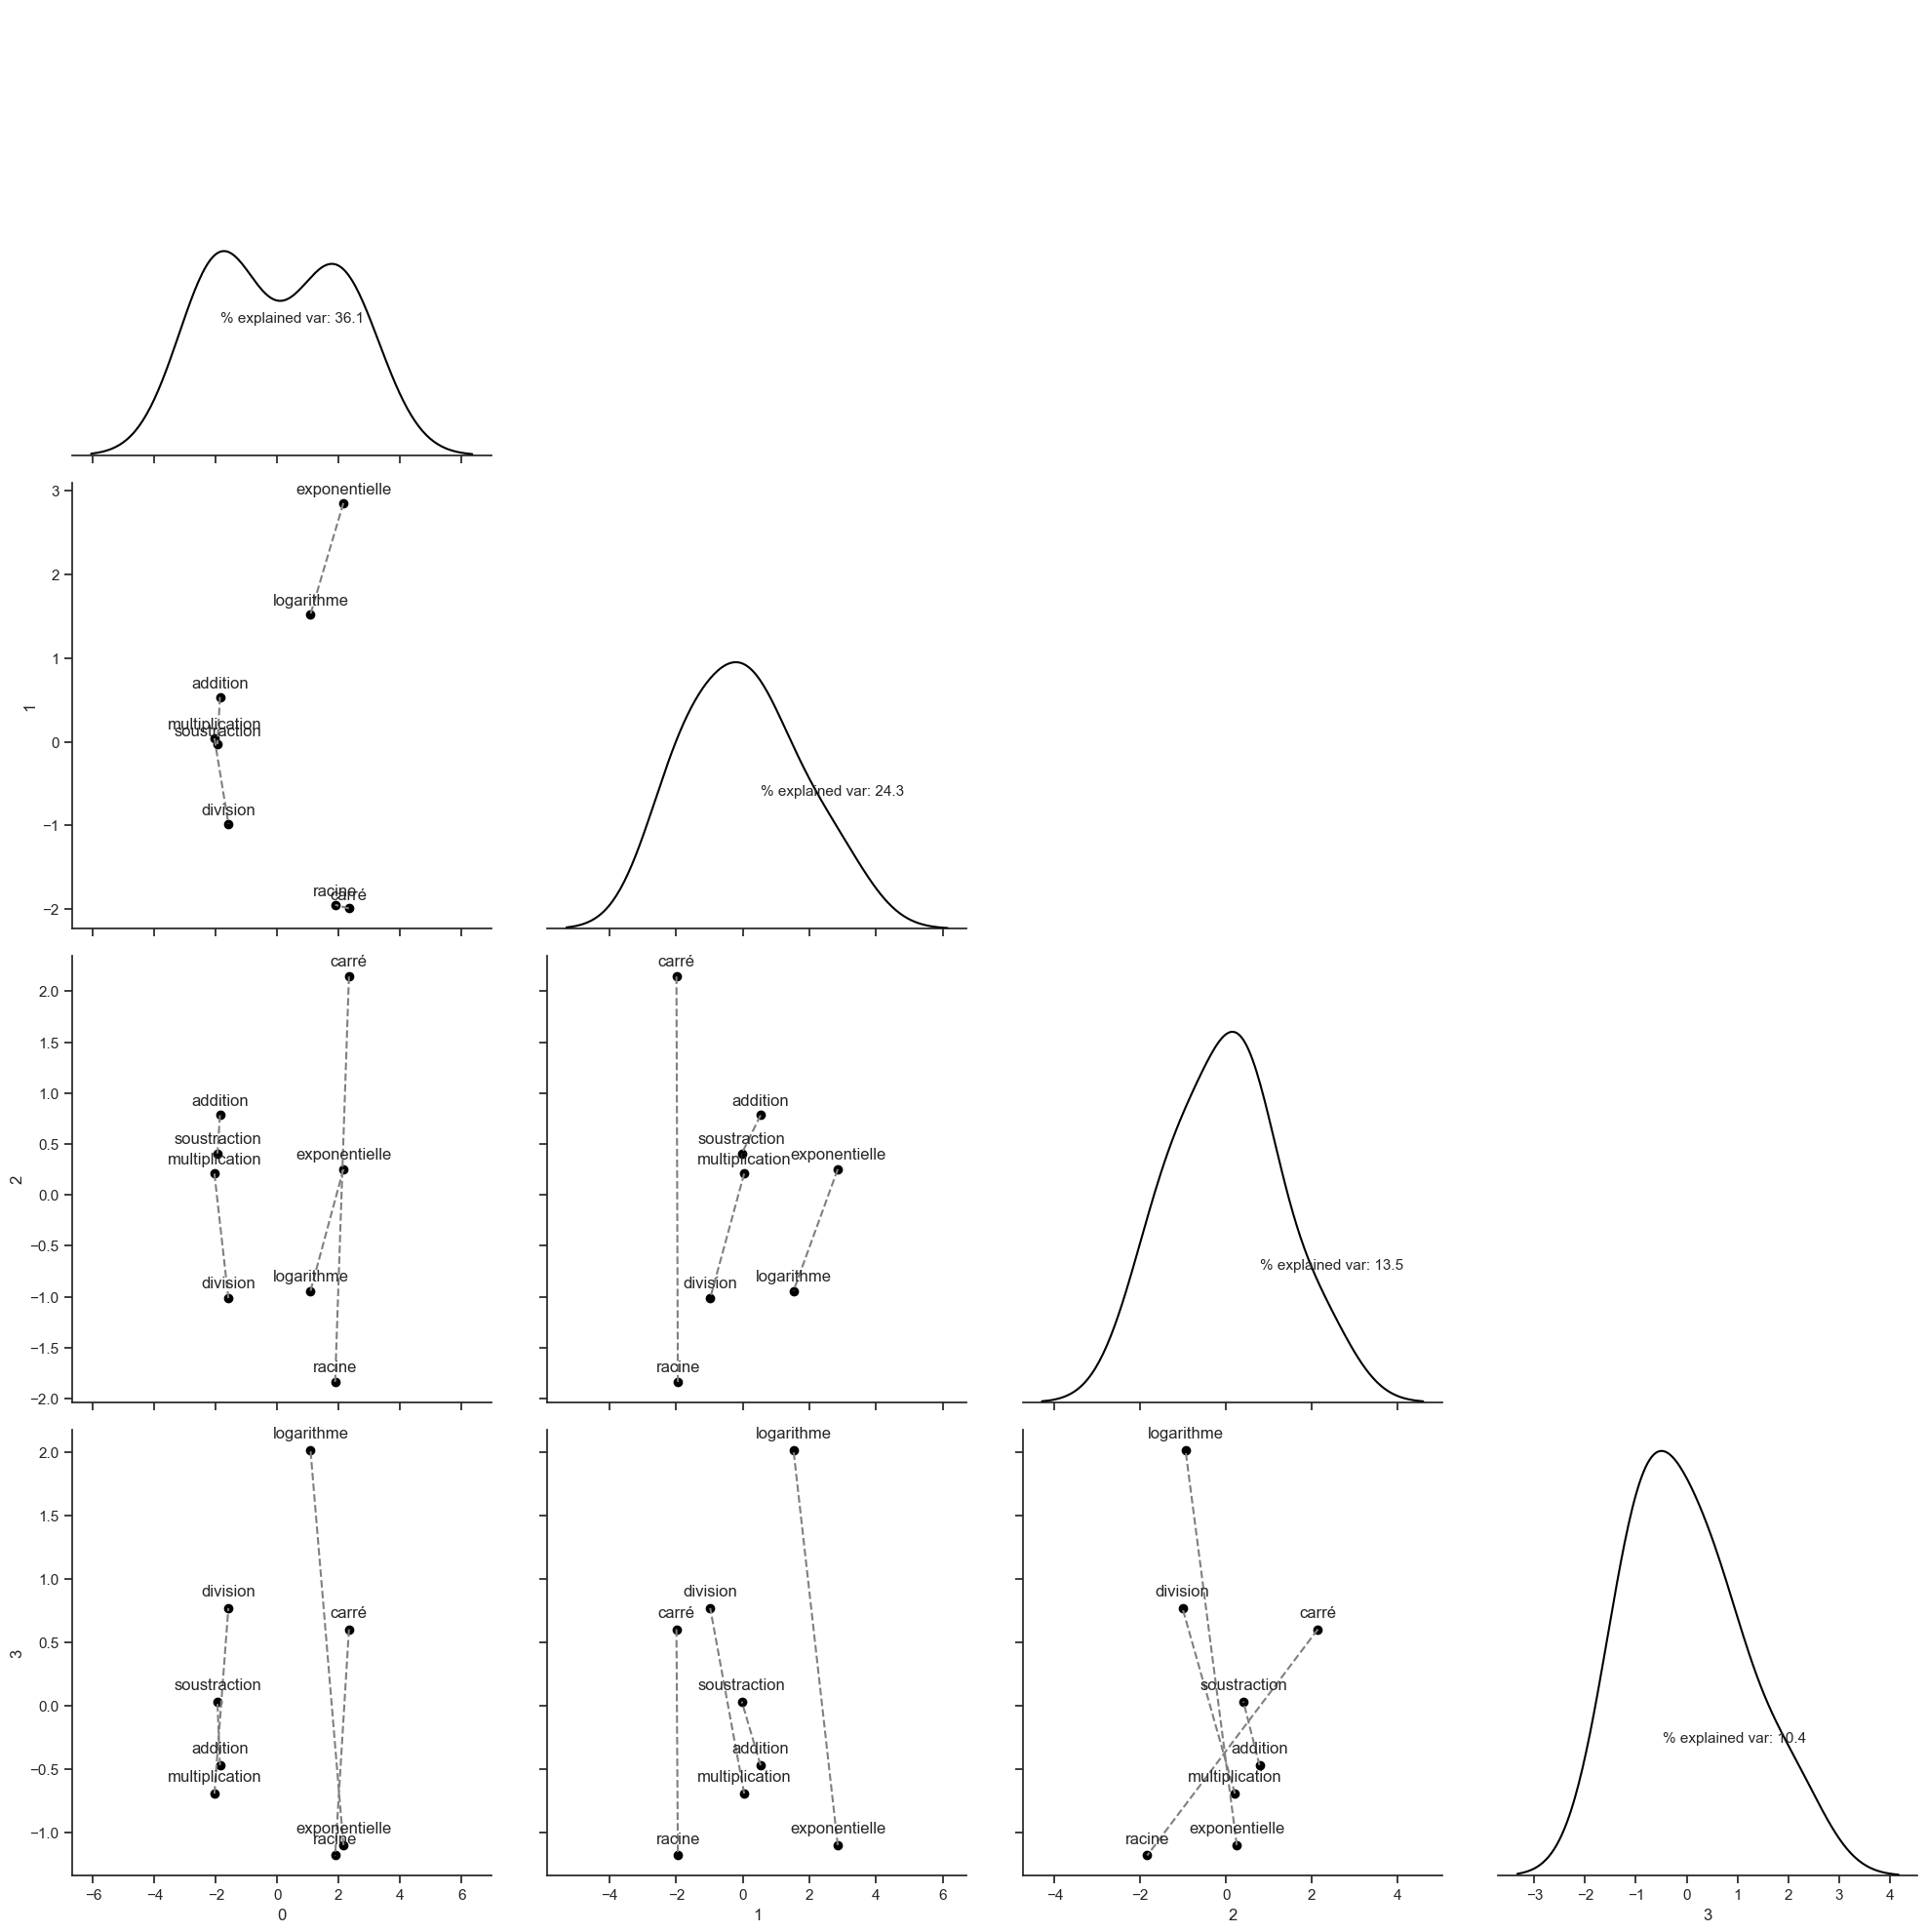

<Figure size 1170x827 with 0 Axes>

In [59]:
PCApairplot(vectors, directOperations, reverseOperations)

## Position on an axis, à la Grand et al.

### Numbers on an axis from 1 to 1 billion

In [60]:
numbers = ['un', 'deux', 'trois', 'quatre', 'cinq', 'six', 'sept', 'huit', 'neuf', 'dix', 'onze', 'douze', 'treize', 'quatorze', 'quinze', 'seize', 'vingt', 'trente', 'quarante', 'cinquante', 'soixante', 'cent', 'mille', 'million', 'milliard']
labels = ['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','20','30','40','50','60','100','$\mathregular{10^3}$','$\mathregular{10^6}$', '$\mathregular{10^9}$']

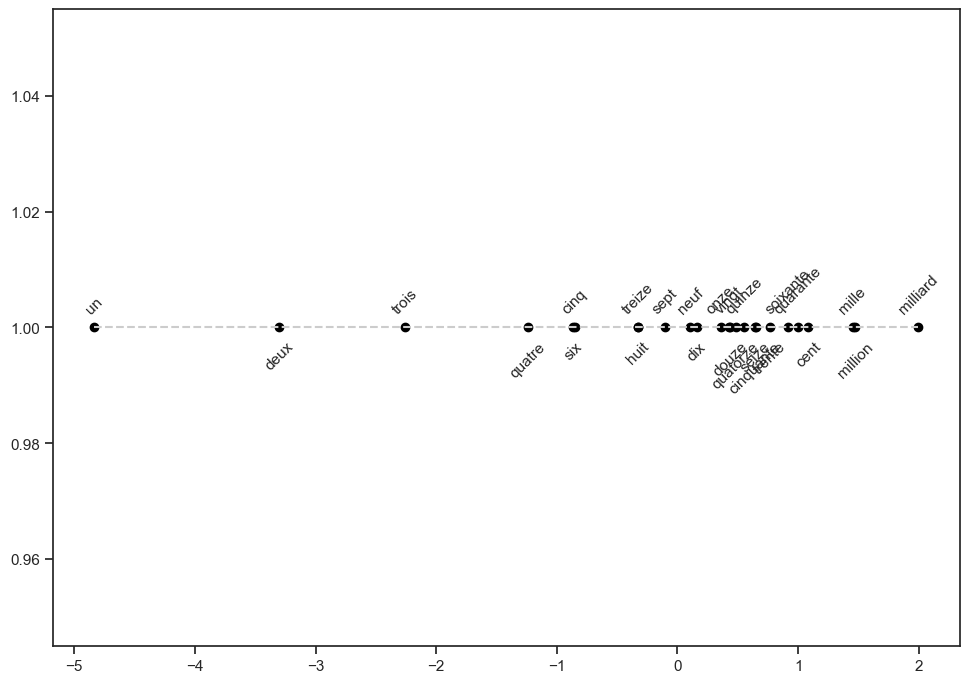

<Figure size 1170x827 with 0 Axes>

In [61]:
plotDistance(vectors, ['un', 'milliard'], numbers)

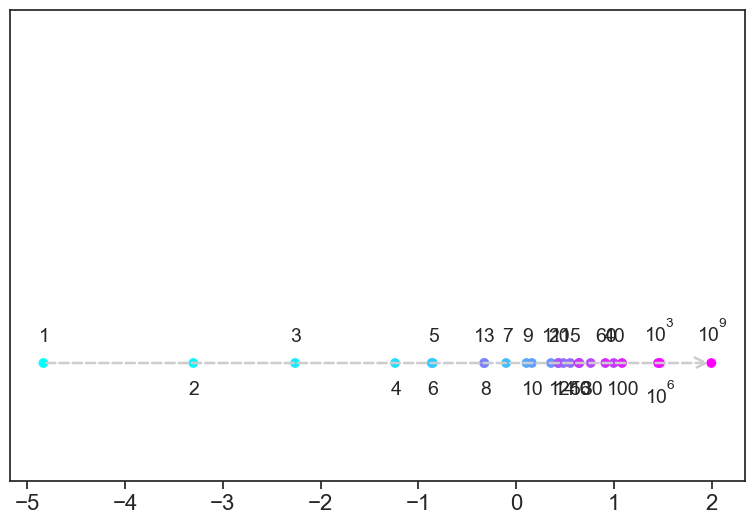

<Figure size 1170x827 with 0 Axes>

In [62]:
# article fig
dist = computeDistance(vectors, ['un', 'milliard'], numbers)

def y(x):
    return 1
    # return .08*(x-dist.loc['milliard'].Coordinate)/(dist.loc['milliard'].Coordinate-dist.loc['un'].Coordinate) + 1.04

# plt.annotate('', xy=(dist.loc['milliard'].Coordinate, 1.04), xytext=(dist.loc['un'].Coordinate, 0.96), arrowprops=dict(arrowstyle='->', color='.8', linestyle='--', mutation_scale=20, linewidth=1.8))
plt.annotate('', xy=(dist.loc['milliard'].Coordinate, 1), xytext=(dist.loc['un'].Coordinate, 1), arrowprops=dict(arrowstyle='->', color='.8', linestyle='--', mutation_scale=20, linewidth=1.8))
plt.scatter(dist['Coordinate'], [y(x) for x in dist['Coordinate']], c=np.arange(len(numbers)), cmap='cool')
for i, (p, l) in enumerate(zip(numbers, labels)):
    off, va = (.0015, 'bottom') if i%2 == 0 else (-0.0015, 'top')
    x = dist.loc[p].Coordinate
    plt.text(x+.01, y(x)+off, l, ha='center', va=va, size=14)

fig = plt.gcf()
ax = plt.gca()
# fig.set_size_inches(2.93, 3.51)
fig.set_size_inches(figWidth, figWidth*0.7)
ax.set(ylim=(0.99, 1.03))
ax.set_yticks(ticks=[], labels=[])
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)
plt.tight_layout()
# plt.savefig("VisuNumericLineLine.png", dpi=300)
# plt.savefig("VisuNumericLineLine.svg", format="svg")
plt.show()
plt.clf()

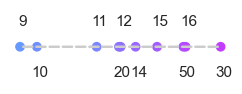

<Figure size 1170x827 with 0 Axes>

In [63]:
# article fig
import cmasher as cmr

dist = computeDistance(vectors, ['un', 'milliard'], numbers)

def y(x):
    return 1
    # return .08*(x-dist.loc['milliard'].Coordinate)/(dist.loc['milliard'].Coordinate-dist.loc['un'].Coordinate) + 1.04

numbersZoom = ['neuf', 'dix', 'onze', 'vingt', 'douze', 'quatorze', 'quinze', 'cinquante', 'seize', 'trente']
distZoom = dist.loc[numbersZoom]
labelsZoom = [9,10,11,20,12,14,15,50,16,30]

# plt.annotate('', xy=(distZoom.loc['neuf'].Coordinate, y(distZoom.loc['neuf'].Coordinate)), xytext=(dist.loc['trente'].Coordinate, y(distZoom.loc['trente'].Coordinate)), 
            #  arrowprops=dict(arrowstyle='-', color='.8', linestyle='--', mutation_scale=20, linewidth=1.8))
plt.annotate('', xy=(distZoom.loc['neuf'].Coordinate, 1), xytext=(dist.loc['trente'].Coordinate, 1), 
             arrowprops=dict(arrowstyle='-', color='.8', linestyle='--', mutation_scale=20, linewidth=1.8))
plt.scatter(distZoom['Coordinate'], [y(x) for x in distZoom['Coordinate']], c=np.arange(len(numbersZoom)), cmap=cmr.get_sub_cmap('cool', 0.4, 0.76))
for i, (p, l) in enumerate(zip(numbersZoom, labelsZoom)):
    off, va = (.0015/3, 'bottom') if i%2 == 0 else (-0.0015/3, 'top')
    x = dist.loc[p].Coordinate
    plt.text(x+.01, y(x)+off, l, ha='center', va=va, size=11)

fig = plt.gcf()
ax = plt.gca()
# fig.set_size_inches(2.93, 3.51)
fig.set_size_inches(figWidth/3, figWidth*.7/5)
ax.set_xticks(ticks=[], labels=[])
ax.set_yticks(ticks=[], labels=[])
ax.set(ylim=(0.999, 1.001))
ax.axis('off')
plt.tight_layout()
# plt.savefig("VisuNumericLineLineZoom.png", dpi=300)
# plt.savefig("VisuNumericLineLineZoom.svg", format="svg")
plt.show()
plt.clf()

### Shapes on an axis from line to hexagon

In [64]:
shapes = ['droite', 'triangle', 'rectangle', 'pentagone', 'hexagone', 'cercle']

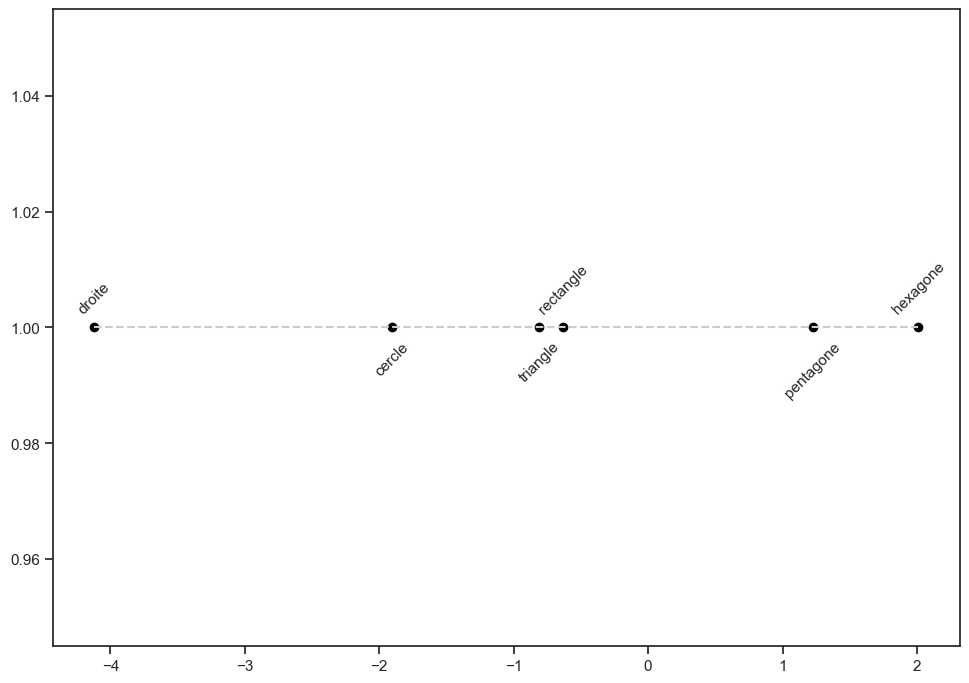

<Figure size 1170x827 with 0 Axes>

In [65]:
plotDistance(vectors, ['droite', 'hexagone'], shapes)

### Sets on an axis from N to C

In [66]:
sets = ["$\mathbb{N}$", "$\mathbb{Z}$", "$\mathbb{Q}$", "$\mathbb{R}$", "$\mathbb{C}$"]

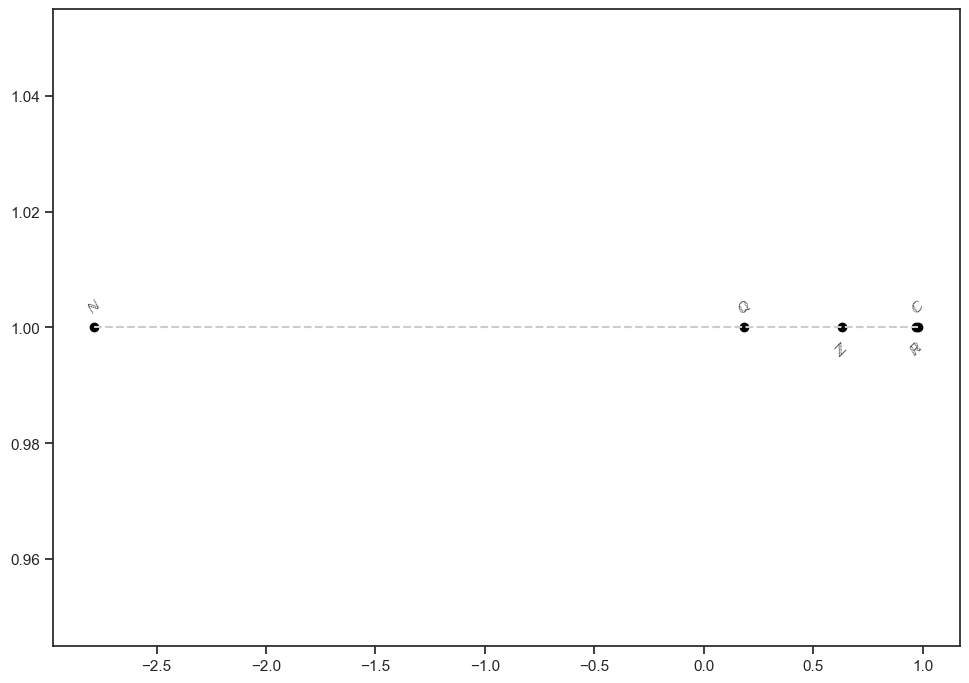

<Figure size 1170x827 with 0 Axes>

In [67]:
plotDistance(vectors, ["$\mathbb{N}$", "$\mathbb{C}$"], sets)

### Algebraic structures on an axis from monoid to algebra

In [68]:
structAlg = ['monoïde', 'groupe', 'anneau', 'corps', 'algèbre']

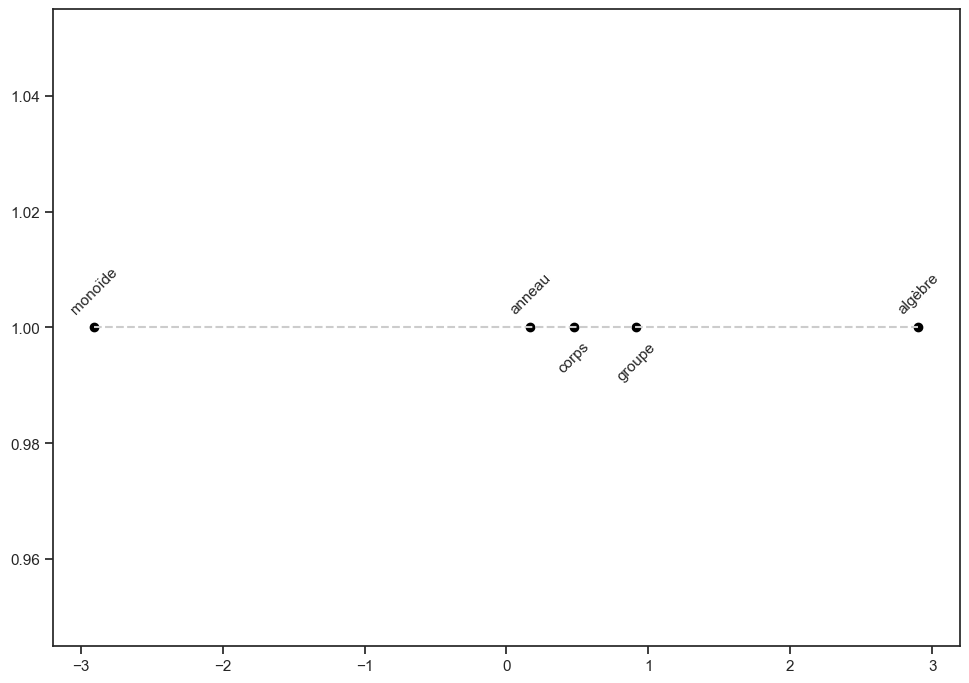

<Figure size 1170x827 with 0 Axes>

In [69]:
plotDistance(vectors, ["monoïde", "algèbre"], structAlg)